# Segmentación de Cartera de Créditos mediante Clustering

## Contexto y Objetivos

El presente análisis tiene como finalidad identificar segmentos homogéneos dentro de la cartera de préstamos de automoción, con el objetivo de:

1. **Caracterizar perfiles de riesgo diferenciados** para optimizar la tarificación del seguro de protección de pagos
2. **Establecer grupos con comportamiento crediticio similar** que permitan estrategias de gestión diferenciadas
3. **Proporcionar una base metodológica sólida** para el desarrollo de modelos predictivos de impago (Objetivo 3 del reto)
4. **Fundamentar el cálculo actuarial** del coste esperado del seguro de protección de pagos (Objetivo 4 del reto)

## Marco Metodológico

Se implementarán y compararán cuatro algoritmos de clustering:

- **K-Means**: Particionamiento basado en centroides con distancia euclidiana
- **Clustering Jerárquico Aglomerativo**: Construcción jerárquica bottom-up con diferentes criterios de enlace (Ward, Complete, Average)
- **DBSCAN**: Algoritmo basado en densidad, robusto a outliers y capaz de detectar clusters de forma arbitraria
- **K-Prototypes**: Extensión de K-Means para datos mixtos (numéricos + categóricos), utilizando distancia euclidiana y distancia de Hamming

La selección del algoritmo óptimo se fundamentará en métricas de validación interna (Silhouette, Davies-Bouldin, Calinski-Harabasz) y validación externa (asociación con tasa de impago).

## Decisiones Metodológicas Clave

### Exclusión de variables con data leakage

**Prima**: Variable calculada *post-facto* con información del riesgo observado. Su inclusión generaría filtración de información de la variable objetivo.

**Meses_Empleo**: Alta correlación con Edad (ρ > 0.80). Se prioriza Edad por mayor interpretabilidad en contexto actuarial y para evitar multicolinealidad.

### Tratamiento de variables categóricas

Para K-Means, Jerárquico y DBSCAN (algoritmos basados en distancia euclidiana):
- Se **excluyen** las variables categóricas nominales (Tipo_Jornada_Laboral, Estado_Civil)
- Razón: El One-Hot Encoding infla artificialmente la dimensionalidad y distorsiona las distancias euclidianas
- Las variables binarias (Fiador, Posesion_Hipoteca) y ordinales (Estudios) se mantienen como numéricas por su naturaleza inherentemente ordinal/binaria

Para K-Prototypes:
- Se **incluyen** las categóricas nominales en su formato original
- El algoritmo utiliza distancia de Hamming para variables categóricas, evitando la necesidad de encoding

### Variables finales para clustering

**10 variables seleccionadas**:
- Financieras continuas (6): Ingresos, Monto_Inicial, Scoring_Crediticio, Ratio_Interes, Duracion, Ratio_Deuda_Ingresos
- Perfil crediticio (4): Num_Creditos, Posesion_Hipoteca, Personas_Cargo, Fiador

Esta selección prioriza variables con capacidad discriminativa demostrada y elimina redundancias para optimizar la calidad de la segmentación.

## 1. Configuración del Entorno e Importación de Librerías

In [1]:
# Librerías de clustering y preprocesamiento
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, cdist
from kmodes.kprototypes import KPrototypes

# Librerías de visualización
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from mpl_toolkits.mplot3d import Axes3D

# Librerías de manipulación de datos
import pandas as pd
import numpy as np
import warnings

# Configuración del entorno
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print('Entorno configurado correctamente')
print(f'Pandas versión: {pd.__version__}')
print(f'NumPy versión: {np.__version__}')

Entorno configurado correctamente
Pandas versión: 2.3.3
NumPy versión: 2.3.5


## 2. Carga y Preparación de Datos

El dataset contiene información de préstamos de automoción con variables financieras, demográficas y de comportamiento crediticio. Se carga el archivo preprocesado donde ya se han tratado valores nulos, outliers y se han creado las variables derivadas necesarias.

In [2]:
# Cargar dataset
df_original = pd.read_csv('Datos/Transformados/df_limpio.csv',index_col="ID")

print('INFORMACIÓN DEL DATASET')
print(f'Dimensiones: {df_original.shape[0]:,} registros × {df_original.shape[1]} variables')
print(f'\nPrimeras observaciones:')
display(df_original.head())

print('\nEstructura del dataset:')
df_original.info()

INFORMACIÓN DEL DATASET
Dimensiones: 50,844 registros × 22 variables

Primeras observaciones:


Edad  Ingresos  Monto_Inicial  Scoring_Crediticio  Meses_Empleo  \
ID                                                                        
S97R7X    18     16000           5000                 397            19   
RLGTBY    50     62116          37278                 486           217   
SKE2P9    37     37602          44532                 765           150   
E2FB1D    56     67410          23752                 643           369   
TKSCGH    35     35930          28440                 645           136   

        Num_Creditos  Ratio_Interes  Duracion  Ratio_Deuda_Ingresos  Estudios  \
ID                                                                              
S97R7X             1         8.0600        48                0.1000         0   
RLGTBY             3        21.9600        12                0.5500         1   
SKE2P9             3        11.2000        60                0.2300         1   
E2FB1D             1        21.2400        24                0.1800         1   
TKSCGH             3        16.9500        12                0.5500         1   

        Posesion_Hipoteca  Personas_Cargo  Fiador  Impago    Prima  \
ID                                                                   
S97R7X                  1               0       0       0  50.1200   
RLGTBY                  1               0       1       1 800.0000   
SKE2P9                  1               1       1       0 356.3000   
E2FB1D                  0               1       0       0 198.7200   
TKSCGH                  1               1       1       0 484.2000   

        Tipo_Jornada_Laboral_Autónomo  Tipo_Jornada_Laboral_Desempleado  \
ID                                                                        
S97R7X                              1                                 0   
RLGTBY                              0                                 0   
SKE2P9                              0                                 0   
E2FB1D                              1                                 0   
TKSCGH                              0                                 0   

        Tipo_Jornada_Laboral_Jornada completa  \
ID                                              
S97R7X                                      0   
RLGTBY                                      0   
SKE2P9                                      0   
E2FB1D                                      0   
TKSCGH                                      1   

        Tipo_Jornada_Laboral_Tiempo parcial  Estado_Civil_Casado  \
ID                                                                 
S97R7X                                    0                    0   
RLGTBY                                    1                    1   
SKE2P9                                    1                    1   
E2FB1D                                    0                    1   
TKSCGH                                    0                    0   

        Estado_Civil_Divorciado  Estado_Civil_Soltero  
ID                                                     
S97R7X                        0                     1  
RLGTBY                        0                     0  
SKE2P9                        0                     0  
E2FB1D                        0                     0  
TKSCGH                        0                     1


Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 50844 entries, S97R7X to O0VB8P
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Edad                                   50844 non-null  int64  
 1   Ingresos                               50844 non-null  int64  
 2   Monto_Inicial                          50844 non-null  int64  
 3   Scoring_Crediticio                     50844 non-null  int64  
 4   Meses_Empleo                           50844 non-null  int64  
 5   Num_Creditos                           50844 non-null  int64  
 6   Ratio_Interes                          50844 non-null  float64
 7   Duracion                               50844 non-null  int64  
 8   Ratio_Deuda_Ingresos                   50844 non-null  float64
 9   Estudios                               50844 non-null  int64  
 10  Posesion_Hipoteca                      50844

In [3]:
# Estadísticas descriptivas de variables numéricas
print('ESTADÍSTICAS DESCRIPTIVAS')
display(df_original.describe())

ESTADÍSTICAS DESCRIPTIVAS


Edad    Ingresos  Monto_Inicial  Scoring_Crediticio  Meses_Empleo  \
count 50844.0000  50844.0000     50844.0000          50844.0000    50844.0000   
mean     43.5465  41576.9342     19956.1309            574.5759      213.0751   
std      15.0391  16061.3612     13669.6724            159.1335      151.2273   
min      18.0000  16000.0000      5000.0000            300.0000        0.0000   
25%      31.0000  30471.0000      9834.0000            437.0000       69.0000   
50%      43.0000  39200.5000     16712.5000            573.0000      207.0000   
75%      57.0000  50195.0000     26210.0000            713.0000      337.0000   
max      69.0000 120000.0000     80000.0000            849.0000      626.0000   

       Num_Creditos  Ratio_Interes   Duracion  Ratio_Deuda_Ingresos  \
count    50844.0000     50844.0000 50844.0000            50844.0000   
mean         2.4962        13.4672    36.0042                0.2086   
std          1.1197         6.6347    17.0039                0.1364   
min          1.0000         2.0000    12.0000                0.1000   
25%          1.0000         7.7400    24.0000                0.1000   
50%          2.0000        13.4200    36.0000                0.1500   
75%          4.0000        19.2300    48.0000                0.2700   
max          4.0000        25.0000    60.0000                0.5500   

        Estudios  Posesion_Hipoteca  Personas_Cargo     Fiador     Impago  \
count 50844.0000         50844.0000      50844.0000 50844.0000 50844.0000   
mean      0.9292             0.5033          0.5009     0.5032     0.1188   
std       0.9244             0.5000          0.5000     0.5000     0.3236   
min       0.0000             0.0000          0.0000     0.0000     0.0000   
25%       0.0000             0.0000          0.0000     0.0000     0.0000   
50%       1.0000             1.0000          1.0000     1.0000     0.0000   
75%       1.0000             1.0000          1.0000     1.0000     0.0000   
max       3.0000             1.0000          1.0000     1.0000     1.0000   

           Prima  Tipo_Jornada_Laboral_Autónomo  \
count 50844.0000                     50844.0000   
mean    209.3793                         0.2501   
std     158.8681                         0.4331   
min      12.5800                         0.0000   
25%      93.3300                         0.0000   
50%     164.8150                         0.0000   
75%     276.3425                         1.0000   
max     800.0000                         1.0000   

       Tipo_Jornada_Laboral_Desempleado  \
count                        50844.0000   
mean                             0.2471   
std                              0.4313   
min                              0.0000   
25%                              0.0000   
50%                              0.0000   
75%                              0.0000   
max                              1.0000   

       Tipo_Jornada_Laboral_Jornada completa  \
count                             50844.0000   
mean                                  0.2495   
std                                   0.4327   
min                                   0.0000   
25%                                   0.0000   
50%                                   0.0000   
75%                                   0.0000   
max                                   1.0000   

       Tipo_Jornada_Laboral_Tiempo parcial  Estado_Civil_Casado  \
count                           50844.0000           50844.0000   
mean                                0.2533               0.5129   
std                                 0.4349               0.4998   
min                                 0.0000               0.0000   
25%                                 0.0000               0.0000   
50%                                 0.0000               1.0000   
75%                                 1.0000               1.0000   
max                                 1.0000               1.0000   

       Estado_Civil_Divorciado  Estado_Civil_Soltero  
count   

## 3. Diagnóstico de Calidad de Variables

### 3.1 Análisis de Varianza

Las variables con baja varianza (>90% valores concentrados en una sola categoría) aportan poca información discriminativa al clustering y deben excluirse del análisis.

In [4]:
# Preparar dataset numérico
df_num = df_original.copy()

# Convertir variables booleanas a numéricas para análisis
bool_cols = df_num.select_dtypes(include='bool').columns
df_num[bool_cols] = df_num[bool_cols].astype(int)

# Análisis de varianza por variable

print('ANÁLISIS DE VARIANZA - IDENTIFICACIÓN DE VARIABLES PROBLEMÁTICAS')

print(f"{'Variable':<40} {'Valores únicos':>15} {'Moda (%)':>12} {'Status':>15}")
print('-'*80)

variables_eliminar = []

for col in df_num.columns:
    unique_count = df_num[col].nunique()
    unique_ratio = unique_count / len(df_num)
    
    if unique_ratio < 0.05:  # Menos del 5% valores únicos
        top_value_count = df_num[col].value_counts().iloc[0]
        top_pct = (top_value_count / len(df_num)) * 100
        
        if top_pct > 90:  # Más del 90% concentrado en un valor
            status = 'ELIMINAR'
            variables_eliminar.append(col)
        else:
            status = 'REVISAR'
        
        print(f"{col:<40} {unique_count:>15,} {top_pct:>11.1f}% {status:>15}")

print()
print(f'Variables identificadas para eliminación: {len(variables_eliminar)}')
for var in variables_eliminar:
    print(f'  - {var}')

ANÁLISIS DE VARIANZA - IDENTIFICACIÓN DE VARIABLES PROBLEMÁTICAS
Variable                                  Valores únicos     Moda (%)          Status
--------------------------------------------------------------------------------
Edad                                                  52         2.1%         REVISAR
Scoring_Crediticio                                   550         0.3%         REVISAR
Meses_Empleo                                         605         6.2%         REVISAR
Num_Creditos                                           4        25.3%         REVISAR
Ratio_Interes                                      2,301         0.1%         REVISAR
Duracion                                               5        20.1%         REVISAR
Ratio_Deuda_Ingresos                                  46        31.9%         REVISAR
Estudios                                               4        38.6%         REVISAR
Posesion_Hipoteca                                      2        50.3%         RE

### 3.2 Análisis de Multicolinealidad

Variables altamente correlacionadas (>0.9) generan redundancia informativa y distorsionan el cálculo de distancias en algoritmos de clustering. Se identifica la correlación entre Edad y Meses_Empleo (r=0.96) como caso crítico que requiere eliminación de una de las dos variables.

In [5]:
# Matriz de correlaciones
corr_matrix = df_num.corr()


print('ANÁLISIS DE MULTICOLINEALIDAD')

print(f"{'Variable 1':<30} {'Variable 2':<30} {'Correlación':>15}")


variables_correlacionadas = []
correlaciones_altas = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            var1, var2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            print(f"{var1:<30} {var2:<30} {corr_val:>15.4f}")
            correlaciones_altas.append((var1, var2, corr_val))
            variables_correlacionadas.extend([var1, var2])

if not correlaciones_altas:
    print('No se detectaron correlaciones superiores a 0.9')
else:
    print(f'\nNOTA: Se recomienda eliminar una de cada par de variables correlacionadas')

ANÁLISIS DE MULTICOLINEALIDAD
Variable 1                     Variable 2                         Correlación
Edad                           Meses_Empleo                            0.9595

NOTA: Se recomienda eliminar una de cada par de variables correlacionadas


### 3.3 Visualización de Matriz de Correlación

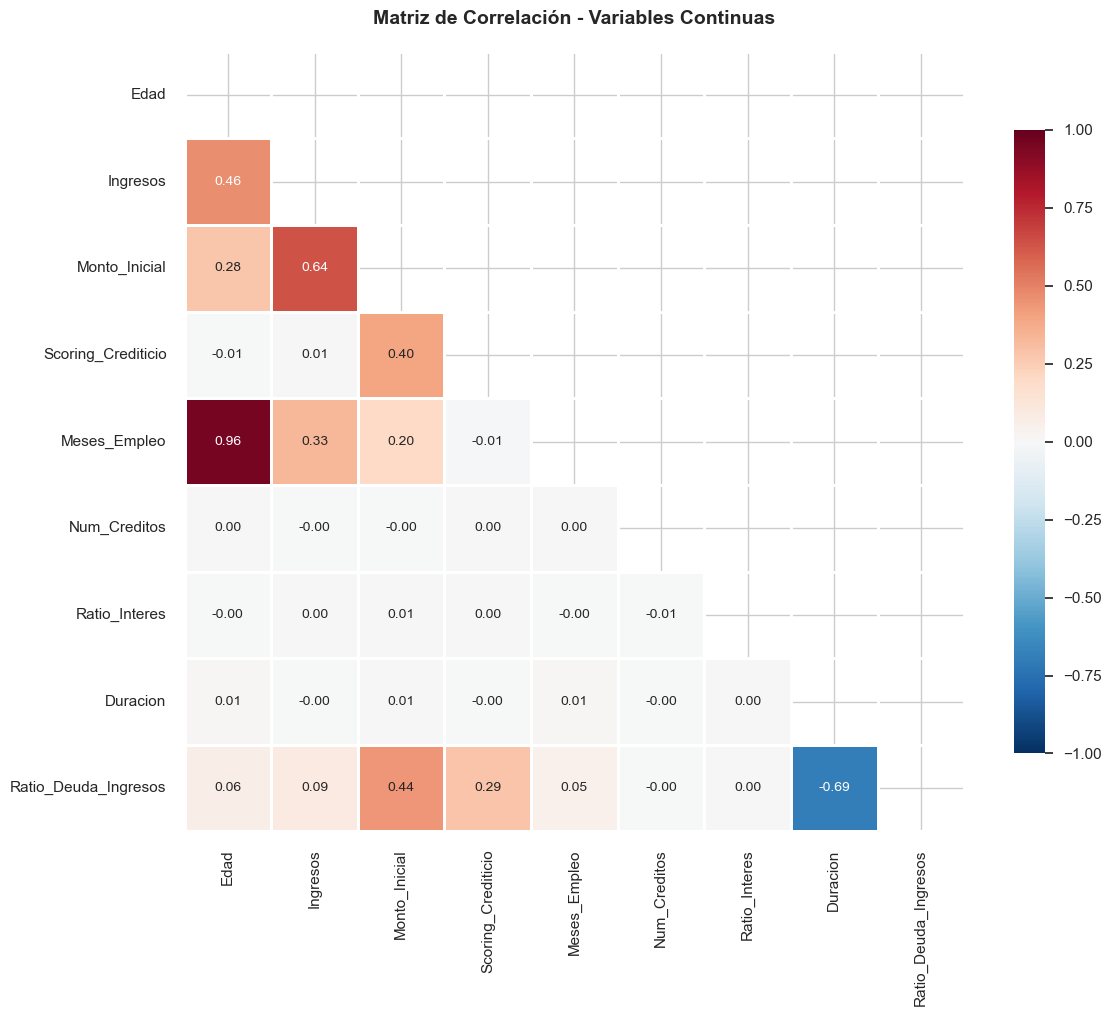

NOTA: Edad y Meses_Empleo muestran correlación muy alta (>0.95)
Se procederá a eliminar Meses_Empleo por ser derivada de Edad


In [6]:
# Heatmap de correlaciones para variables continuas clave
vars_continuas = ['Edad', 'Ingresos', 'Monto_Inicial', 'Scoring_Crediticio',
                  'Meses_Empleo', 'Num_Creditos', 'Ratio_Interes', 'Duracion',
                  'Ratio_Deuda_Ingresos']

plt.figure(figsize=(12, 10))
corr_continuas = df_num[vars_continuas].corr()
mask = np.triu(np.ones_like(corr_continuas, dtype=bool))
sns.heatmap(corr_continuas, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Continuas', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print('NOTA: Edad y Meses_Empleo muestran correlación muy alta (>0.95)')
print('Se procederá a eliminar Meses_Empleo por ser derivada de Edad')

## 4 Selección Final de Variables para Clustering

La selección de variables se fundamenta en tres criterios:

1. **Capacidad discriminativa**: Variables con coeficiente de variación (CV) > 0.3
2. **Independencia de la variable objetivo**: Exclusión de variables con data leakage
3. **Ausencia de multicolinealidad severa**: VIF < 10 entre variables seleccionadas

Este proceso garantiza que el clustering capture patrones estructurales del perfil de prestatarios, no artefactos del procesamiento de datos o correlaciones espurias.

**Variables Excluidas y Justificación:**

- **Prima**: Variable derivada que incorpora evaluación de riesgo del asegurador. Su inclusión generaría:
  - Redundancia informativa (combina variables ya incluidas)
  - Sesgo de endogeneidad (puede contener información del target)
  - Pérdida de aplicabilidad (no disponible al momento de solicitud del crédito)
  
- **Impago**: Variable objetivo del Objetivo 3 del reto. Su exclusión evita:
  - Data leakage (usar el resultado para definir grupos)
  - Violación del principio de clustering no supervisado
  - Se utilizará posteriormente solo para validación

- **Variables personales**: Variables que aportan informacion personal como edad, meses de empleo,etc se has excluido debido a la mala caracterizacion del cluster con ellos.



In [7]:
# Definir conjunto de variables para clustering

# Variables continuas base (métricas de riesgo crediticio)
variables_clustering = [
    # Variables continuas financieras (6)
    'Ingresos',
    'Monto_Inicial',
    'Scoring_Crediticio',
    'Ratio_Interes',
    'Duracion',
    'Ratio_Deuda_Ingresos',
    
    # Variables de perfil crediticio/familiar (4)
    'Num_Creditos',               
    'Posesion_Hipoteca',      
    'Personas_Cargo',           
    'Fiador',

                       
]

# Crear DataFrame para clustering
df_clustering = df_original[variables_clustering].copy()

# Guardar variable objetivo para validación posterior
impago_validacion = df_original['Impago'].copy()


print('VARIABLES SELECCIONADAS PARA CLUSTERING')

print(f'\nTotal de variables: {len(variables_clustering)}')
print(f'\nListado de variables:')
for i, var in enumerate(variables_clustering, 1):
    print(f'  {i:2d}. {var}')


print('ESTADÍSTICAS DESCRIPTIVAS - DATASET DE CLUSTERING')

display(df_clustering.describe())

# Verificar datos faltantes
print('\nVerificación de datos faltantes:')
missing = df_clustering.isnull().sum()
if missing.sum() == 0:
    print('  No se detectaron valores faltantes')
else:
    print(missing[missing > 0])

VARIABLES SELECCIONADAS PARA CLUSTERING

Total de variables: 10

Listado de variables:
   1. Ingresos
   2. Monto_Inicial
   3. Scoring_Crediticio
   4. Ratio_Interes
   5. Duracion
   6. Ratio_Deuda_Ingresos
   7. Num_Creditos
   8. Posesion_Hipoteca
   9. Personas_Cargo
  10. Fiador
ESTADÍSTICAS DESCRIPTIVAS - DATASET DE CLUSTERING


Ingresos  Monto_Inicial  Scoring_Crediticio  Ratio_Interes  \
count  50844.0000     50844.0000          50844.0000     50844.0000   
mean   41576.9342     19956.1309            574.5759        13.4672   
std    16061.3612     13669.6724            159.1335         6.6347   
min    16000.0000      5000.0000            300.0000         2.0000   
25%    30471.0000      9834.0000            437.0000         7.7400   
50%    39200.5000     16712.5000            573.0000        13.4200   
75%    50195.0000     26210.0000            713.0000        19.2300   
max   120000.0000     80000.0000            849.0000        25.0000   

        Duracion  Ratio_Deuda_Ingresos  Num_Creditos  Posesion_Hipoteca  \
count 50844.0000            50844.0000    50844.0000         50844.0000   
mean     36.0042                0.2086        2.4962             0.5033   
std      17.0039                0.1364        1.1197             0.5000   
min      12.0000                0.1000        1.0000             0.0000   
25%      24.0000                0.1000        1.0000             0.0000   
50%      36.0000                0.1500        2.0000             1.0000   
75%      48.0000                0.2700        4.0000             1.0000   
max      60.0000                0.5500        4.0000             1.0000   

       Personas_Cargo     Fiador  
count      50844.0000 50844.0000  
mean           0.5009     0.5032  
std            0.5000     0.5000  
min            0.0000     0.0000  
25%            0.0000     0.0000  
50%            1.0000     1.0000  
75%            1.0000     1.0000  
max            1.0000     1.0000


Verificación de datos faltantes:
  No se detectaron valores faltantes


## 5. Estandarización de Datos

**Justificación Técnica:**

Los algoritmos de clustering basados en distancias (K-Means, Jerárquico, DBSCAN) son altamente sensibles a la escala de las variables. La estandarización Z-score es imperativa por:

1. **Eliminación del efecto escala**: Variables como Ingresos (rango: 16,000-100,000) dominarían sobre Ratio_Deuda_Ingresos (rango: 0-1) en el cálculo de distancias euclidianas sin reflejar necesariamente mayor importancia

2. **Equidad contributiva**: Tras estandarización, cada variable contribuye equitativamente a la distancia total, permitiendo que el algoritmo detecte patrones en todas las dimensiones

3. **Convergencia algorítmica**: En K-Means, la convergencia es más rápida y estable cuando todas las variables tienen varianza unitaria

**Transformación Aplicada:**

$$z = \frac{x - \mu}{\sigma}$$

Donde:
- $x$ = valor original de la variable
- $\mu$ = media de la variable
- $\sigma$ = desviación estándar de la variable  
- $z$ = valor estandarizado (media=0, std=1)

In [8]:
# Aplicar estandarización Z-score

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled, columns=df_clustering.columns, index=df_clustering.index)


print('ESTANDARIZACIÓN COMPLETADA')


# Verificación de estandarización
print('\nVerificación de propiedades estadísticas post-estandarización:')
print(f'  Media global: {df_scaled.mean().mean():.10f} (objetivo: 0.000000)')
print(f'  Desviación estándar global: {df_scaled.std().mean():.6f} (objetivo: 1.000000)')

print('\nEstadísticas por variable:')
stats = pd.DataFrame({
    'Media': df_scaled.mean(),
    'Std': df_scaled.std(),
    'Min': df_scaled.min(),
    'Max': df_scaled.max()
})
display(stats)

print('\nMuestra de datos estandarizados:')
display(df_scaled.head(10))

ESTANDARIZACIÓN COMPLETADA

Verificación de propiedades estadísticas post-estandarización:
  Media global: 0.0000000000 (objetivo: 0.000000)
  Desviación estándar global: 1.000010 (objetivo: 1.000000)

Estadísticas por variable:


Media    Std     Min    Max
Ingresos              0.0000 1.0000 -1.5925 4.8828
Monto_Inicial        -0.0000 1.0000 -1.0941 4.3925
Scoring_Crediticio    0.0000 1.0000 -1.7255 1.7245
Ratio_Interes         0.0000 1.0000 -1.7284 1.7383
Duracion             -0.0000 1.0000 -1.4117 1.4112
Ratio_Deuda_Ingresos -0.0000 1.0000 -0.7961 2.5019
Num_Creditos         -0.0000 1.0000 -1.3362 1.3430
Posesion_Hipoteca     0.0000 1.0000 -1.0067 0.9933
Personas_Cargo        0.0000 1.0000 -1.0017 0.9983
Fiador               -0.0000 1.0000 -1.0064 0.9936


Muestra de datos estandarizados:


Ingresos  Monto_Inicial  Scoring_Crediticio  Ratio_Interes  Duracion  \
ID                                                                             
S97R7X   -1.5925        -1.0941             -1.1159        -0.8150    0.7055   
RLGTBY    1.2788         1.2672             -0.5566         1.2801   -1.4117   
SKE2P9   -0.2475         1.7979              1.1966        -0.3417    1.4112   
E2FB1D    1.6084         0.2777              0.4300         1.1716   -0.7060   
TKSCGH   -0.3516         0.6206              0.4426         0.5249   -1.4117   
8CI0EZ   -0.0213         1.0604             -0.4624         0.6561    0.7055   
NBL3DD   -0.4443         0.0982             -0.1921         1.4067   -1.4117   
ABRPBC   -1.5925        -1.0941             -1.2164        -1.2054   -0.0002   
JU5UY4   -1.4460        -0.9251              1.6680         0.2114    1.4112   
6789JG    1.4671         2.1313              0.8636        -0.4985   -0.0002   

        Ratio_Deuda_Ingresos  Num_Creditos  Posesion_Hipoteca  Personas_Cargo  \
ID                                                                              
S97R7X               -0.7961       -1.3362             0.9933         -1.0017   
RLGTBY                2.5019        0.4499             0.9933         -1.0017   
SKE2P9                0.1567        0.4499             0.9933          0.9983   
E2FB1D               -0.2098       -1.3362            -1.0067          0.9983   
TKSCGH                2.5019        0.4499             0.9933          0.9983   
8CI0EZ               -0.2098        0.4499            -1.0067         -1.0017   
NBL3DD                2.5019       -0.4432             0.9933          0.9983   
ABRPBC               -0.7961       -1.3362            -1.0067          0.9983   
JU5UY4               -0.7961        0.4499            -1.0067          0.9983   
6789JG                0.4498        1.3430             0.9933          0.9983   

        Fiador  
ID              
S97R7X -1.0064  
RLGTBY  0.9936  
SKE2P9  0.9936  
E2FB1D -1.0064  
TKSCGH  0.9936  
8CI0EZ  0.9936  
NBL3DD -1.0064  
ABRPBC -1.0064  
JU5UY4 -1.0064  
6789JG  0.9936

## 6. Análisis de Componentes Principales (PCA)

**Objetivos del PCA:**

1. **Evaluación de dimensionalidad efectiva**: Determinar cuántas componentes capturan la mayor parte de la varianza
2. **Visualización bidimensional**: Proyectar datos a 2D para representación gráfica de la estructura
3. **Diagnóstico de complejidad**: Identificar si los datos presentan estructura comprimible o distribuida

**Nota Metodológica Importante:**

PCA se utiliza exclusivamente para análisis exploratorio y visualización. El clustering se realiza sobre el espacio original de 9 variables para preservar toda la información disponible y mantener interpretabilidad de los clusters en términos de las variables originales.

In [9]:
# PCA completo para análisis de varianza

pca_full = PCA()
pca_full.fit(df_scaled)

# Calcular varianza explicada acumulada
varianza_explicada = pca_full.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

# Determinar número de componentes para umbrales específicos
n_comp_80 = np.argmax(varianza_acumulada >= 0.80) + 1
n_comp_90 = np.argmax(varianza_acumulada >= 0.90) + 1
n_comp_95 = np.argmax(varianza_acumulada >= 0.95) + 1


print('ANÁLISIS DE COMPONENTES PRINCIPALES')

print(f'\nNúmero total de componentes: {len(varianza_explicada)}')
print(f'\nVarianza explicada por primeras componentes:')
print(f'  PC1: {varianza_explicada[0]*100:6.2f}%')
print(f'  PC2: {varianza_explicada[1]*100:6.2f}%')
print(f'  PC1 + PC2: {varianza_explicada[:2].sum()*100:6.2f}%')
print(f'\nComponentes necesarias para capturar:')
print(f'  80% de varianza: {n_comp_80} componentes')
print(f'  90% de varianza: {n_comp_90} componentes')
print(f'  95% de varianza: {n_comp_95} componentes')

# Tabla de varianza por componente
print('\nDetalle de varianza por componente:')
pca_df = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(varianza_explicada))],
    'Varianza (%)': varianza_explicada * 100,
    'Varianza Acumulada (%)': varianza_acumulada * 100
})
display(pca_df)

ANÁLISIS DE COMPONENTES PRINCIPALES

Número total de componentes: 10

Varianza explicada por primeras componentes:
  PC1:  21.09%
  PC2:  14.48%
  PC1 + PC2:  35.57%

Componentes necesarias para capturar:
  80% de varianza: 7 componentes
  90% de varianza: 8 componentes
  95% de varianza: 8 componentes

Detalle de varianza por componente:


Componente  Varianza (%)  Varianza Acumulada (%)
0        PC1       21.0894                 21.0894
1        PC2       14.4766                 35.5660
2        PC3       10.0968                 45.6628
3        PC4       10.0657                 55.7285
4        PC5        9.9948                 65.7233
5        PC6        9.9491                 75.6724
6        PC7        9.9273                 85.5997
7        PC8        9.9076                 95.5073
8        PC9        3.3878                 98.8951
9       PC10        1.1049                100.0000

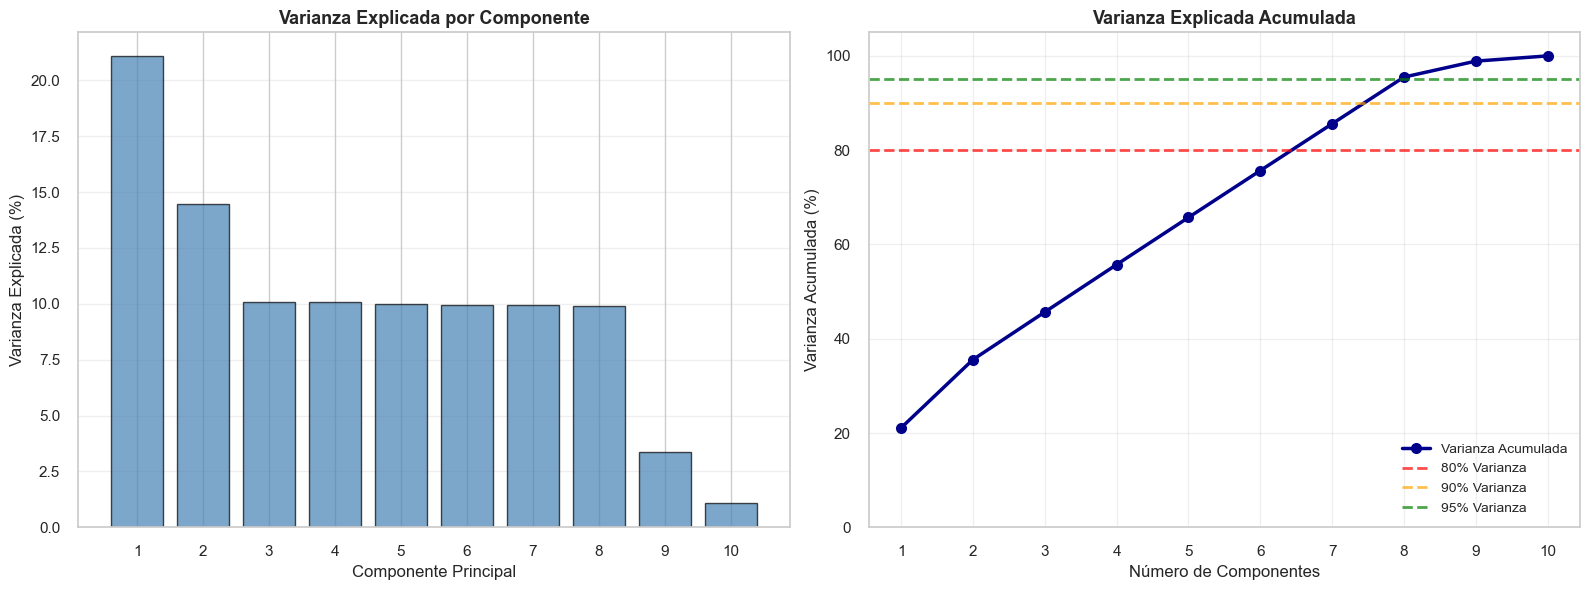

INTERPRETACIÓN:
  - Las primeras 2 componentes capturan 35.6% de la varianza
  - Se requieren 8 componentes para capturar el 90% de la información
  - La alta dimensionalidad efectiva sugiere que los datos no presentan
    una estructura altamente comprimible


In [10]:
# Visualización de varianza explicada

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Varianza individual por componente
ax1.bar(range(1, len(varianza_explicada)+1), varianza_explicada*100, 
        alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Componente Principal', fontsize=12)
ax1.set_ylabel('Varianza Explicada (%)', fontsize=12)
ax1.set_title('Varianza Explicada por Componente', fontweight='bold', fontsize=13)
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticks(range(1, len(varianza_explicada)+1))

# Gráfico 2: Varianza acumulada
ax2.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada*100, 
         'o-', linewidth=2.5, markersize=8, color='darkblue', label='Varianza Acumulada')
ax2.axhline(y=80, color='red', linestyle='--', linewidth=2, alpha=0.7, label='80% Varianza')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='90% Varianza')
ax2.axhline(y=95, color='green', linestyle='--', linewidth=2, alpha=0.7, label='95% Varianza')
ax2.set_xlabel('Número de Componentes', fontsize=12)
ax2.set_ylabel('Varianza Acumulada (%)', fontsize=12)
ax2.set_title('Varianza Explicada Acumulada', fontweight='bold', fontsize=13)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, len(varianza_acumulada)+1))
ax2.set_ylim([0, 105])

plt.tight_layout()
plt.show()

print('INTERPRETACIÓN:')
print(f'  - Las primeras 2 componentes capturan {varianza_explicada[:2].sum()*100:.1f}% de la varianza')
print(f'  - Se requieren {n_comp_90} componentes para capturar el 90% de la información')
print('  - La alta dimensionalidad efectiva sugiere que los datos no presentan')
print('    una estructura altamente comprimible')

In [11]:
# Proyección 2D para visualización

pca_3d = PCA(n_components=3, random_state=42)
df_pca_3d = pca_3d.fit_transform(df_scaled)

# Análisis de loadings (contribución de variables originales a componentes)
loadings = pd.DataFrame(
    pca_3d.components_.T,
    columns=['PC1', 'PC2',"PC3"],
    index=df_clustering.columns
)


print('LOADINGS - CONTRIBUCIÓN DE VARIABLES A COMPONENTES PRINCIPALES')

display(loadings.style.background_gradient(cmap='RdBu_r', axis=0))

print('\nINTERPRETACIÓN DE COMPONENTES:')
print('\nPC1 (Primera Componente Principal):')
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(3)
for var, loading in top_pc1.items():
    print(f'  - {var}: {loadings.loc[var, "PC1"]:+.3f}')

print('\nPC2 (Segunda Componente Principal):')
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(3)
for var, loading in top_pc2.items():
    print(f'  - {var}: {loadings.loc[var, "PC2"]:+.3f}')

print('\nPC3 (Segunda Componente Principal):')
top_pc3 = loadings['PC3'].abs().sort_values(ascending=False).head(3)
for var, loading in top_pc3.items():
    print(f'  - {var}: {loadings.loc[var, "PC3"]:+.3f}')

LOADINGS - CONTRIBUCIÓN DE VARIABLES A COMPONENTES PRINCIPALES



INTERPRETACIÓN DE COMPONENTES:

PC1 (Primera Componente Principal):
  - Ratio_Deuda_Ingresos: +0.560
  - Monto_Inicial: +0.555
  - Ingresos: +0.368

PC2 (Segunda Componente Principal):
  - Duracion: +0.634
  - Ingresos: +0.500
  - Monto_Inicial: +0.413

PC3 (Segunda Componente Principal):
  - Num_Creditos: +0.630
  - Fiador: -0.522
  - Posesion_Hipoteca: +0.415


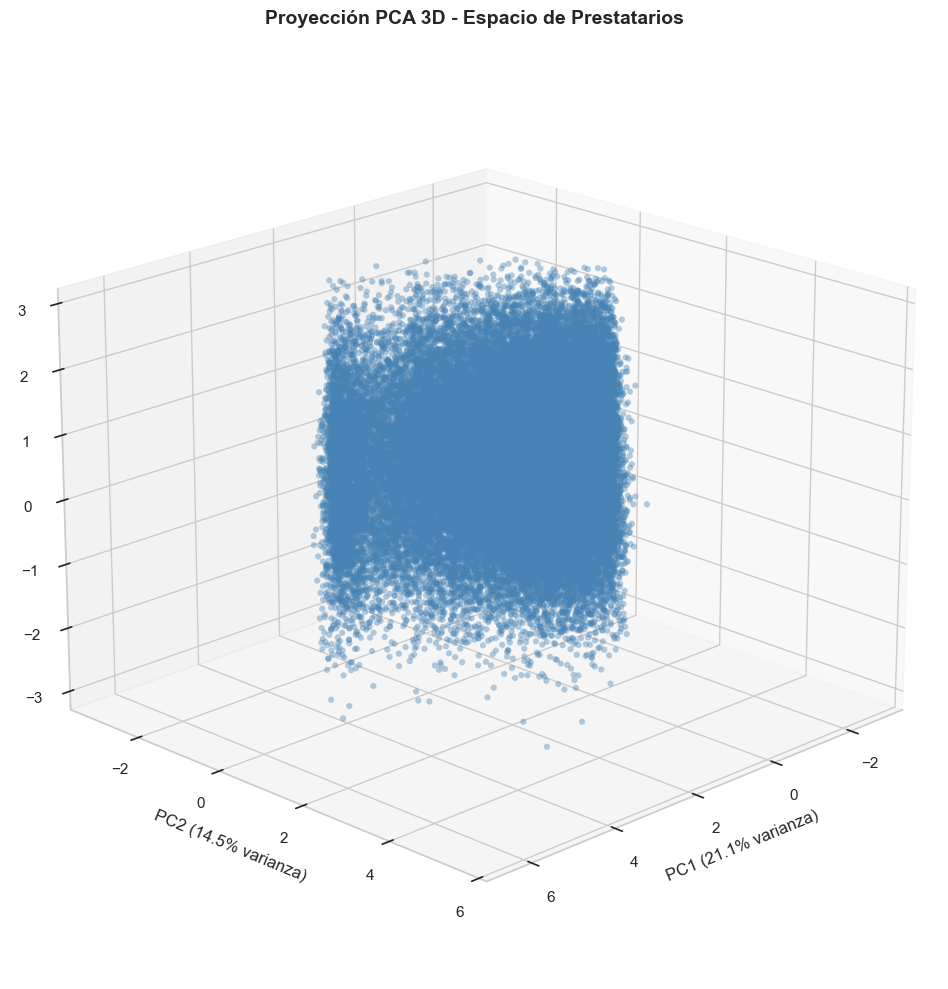

OBSERVACIONES:
  - Los datos forman una distribución continua sin clusters claramente separados
  - Esto es esperable en datos de riesgo crediticio (continuum de riesgo)
  - Los algoritmos de clustering identificarán regiones de densidad relativa


In [12]:
# Visualización de proyección 2D


fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca_3d[:, 0], df_pca_3d[:, 1], df_pca_3d[:, 2],
            alpha=0.4, s=20, c='steelblue', edgecolors='none')

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)

ax.set_title('Proyección PCA 3D - Espacio de Prestatarios', 
          fontweight='bold', fontsize=14, pad=20)

ax.grid(True, alpha=0.3)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print('OBSERVACIONES:')
print('  - Los datos forman una distribución continua sin clusters claramente separados')
print('  - Esto es esperable en datos de riesgo crediticio (continuum de riesgo)')
print('  - Los algoritmos de clustering identificarán regiones de densidad relativa')

## 7. K-Means Clustering

### 7.1 Determinación del Número Óptimo de Clusters

Se aplican múltiples criterios complementarios para seleccionar el número óptimo de clusters (k):

**Método del Codo (Elbow Method):**
Analiza la tasa de decrecimiento de la inercia (WCSS) al incrementar k. El "codo" indica balance óptimo entre complejidad del modelo y calidad de ajuste.

**Coeficiente de Silueta:**
Mide calidad de asignación comparando cohesión intra-cluster con separación inter-cluster.
- Rango: [-1, 1]
- s ≈ 1: excelente asignación (punto muy cercano a su cluster, lejos de otros)
- s ≈ 0: punto en frontera entre clusters
- s < 0: posible mala asignación

**Índice Davies-Bouldin:**
Evalúa ratio promedio entre dispersión intra-cluster y separación inter-cluster.
Menor DB indica mejor clustering (clusters compactos y bien separados).

**Índice Calinski-Harabasz:**
Ratio de dispersión inter-cluster a dispersión intra-cluster.
Mayor CH indica mejor separación relativa entre clusters.

DETERMINACIÓN DE NÚMERO ÓPTIMO DE CLUSTERS - MÉTODO DEL CODO


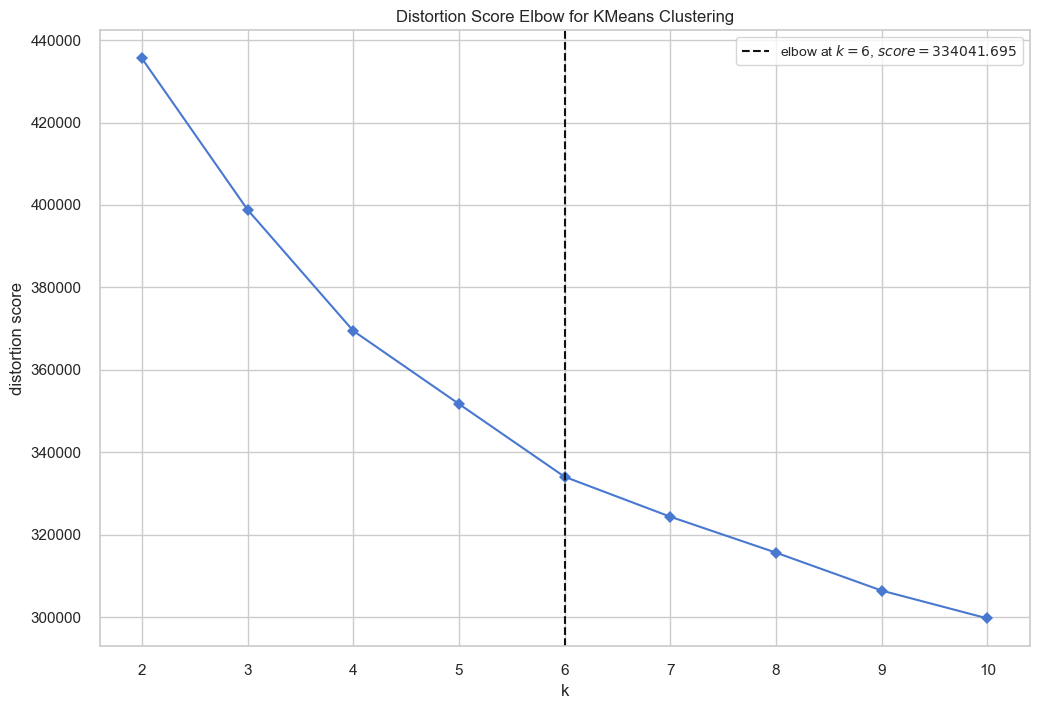


Número de clusters sugerido por método del codo: k = 6


In [13]:
# Método del Codo con Yellowbrick

print('DETERMINACIÓN DE NÚMERO ÓPTIMO DE CLUSTERS - MÉTODO DEL CODO')


model = KMeans(random_state=42, n_init=20)
visualizer = KElbowVisualizer(model, k=(2, 11), metric='distortion', timings=False)
visualizer.fit(df_scaled)
visualizer.show()

k_elbow = visualizer.elbow_value_
print(f'\nNúmero de clusters sugerido por método del codo: k = {k_elbow}')

In [14]:
# Análisis exhaustivo de métricas de validación

k_range = range(2, 11)
metricas_kmeans = []


print('EVALUACIÓN DE MÉTRICAS DE CLUSTERING POR NÚMERO DE CLUSTERS')

print(f"{'k':^5} | {'Inercia':^15} | {'Silueta':^12} | {'Davies-Bouldin':^18} | {'Calinski-Harabasz':^20}")
print('-'*100)

for k in k_range:
    # Ejecutar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = kmeans.fit_predict(df_scaled)
    
    # Calcular métricas
    inercia = kmeans.inertia_
    silueta = silhouette_score(df_scaled, labels)
    db = davies_bouldin_score(df_scaled, labels)
    ch = calinski_harabasz_score(df_scaled, labels)
    
    metricas_kmeans.append({
        'k': k,
        'Inercia': inercia,
        'Silueta': silueta,
        'Davies-Bouldin': db,
        'Calinski-Harabasz': ch
    })
    print(f"{k:^5} | {inercia:>15.2f} | {silueta:>12.4f} | {db:>18.4f} | {ch:>20.2f}")



# Convertir a DataFrame para análisis
df_metricas_kmeans = pd.DataFrame(metricas_kmeans)

# Identificar k óptimo por cada métrica
k_mejor_silueta = df_metricas_kmeans.loc[df_metricas_kmeans['Silueta'].idxmax(), 'k']
k_mejor_db = df_metricas_kmeans.loc[df_metricas_kmeans['Davies-Bouldin'].idxmin(), 'k']
k_mejor_ch = df_metricas_kmeans.loc[df_metricas_kmeans['Calinski-Harabasz'].idxmax(), 'k']

print('\nVALORES ÓPTIMOS POR MÉTRICA:')
print(f'  Mejor Silueta (maximizar):       k = {k_mejor_silueta} (Silueta = {df_metricas_kmeans.loc[df_metricas_kmeans["k"]==k_mejor_silueta, "Silueta"].values[0]:.4f})')
print(f'  Mejor Davies-Bouldin (minimizar): k = {k_mejor_db} (DB = {df_metricas_kmeans.loc[df_metricas_kmeans["k"]==k_mejor_db, "Davies-Bouldin"].values[0]:.4f})')
print(f'  Mejor Calinski-Harabasz (maximizar): k = {k_mejor_ch} (CH = {df_metricas_kmeans.loc[df_metricas_kmeans["k"]==k_mejor_ch, "Calinski-Harabasz"].values[0]:.2f})')

EVALUACIÓN DE MÉTRICAS DE CLUSTERING POR NÚMERO DE CLUSTERS
  k   |     Inercia     |   Silueta    |   Davies-Bouldin   |  Calinski-Harabasz  
----------------------------------------------------------------------------------------------------
  2   |       435567.39 |       0.1584 |             2.3004 |              8506.14
  3   |       398850.00 |       0.1156 |             2.4195 |              6984.68
  4   |       369458.55 |       0.1185 |             2.2529 |              6374.97
  5   |       351722.78 |       0.1102 |             2.1589 |              5663.10
  6   |       334041.99 |       0.1315 |             2.2154 |              5308.36
  7   |       324352.48 |       0.1209 |             2.2385 |              4808.80
  8   |       315637.01 |       0.1095 |             2.1631 |              4436.10
  9   |       306426.82 |       0.1227 |             2.1516 |              4189.16
 10   |       299680.70 |       0.1217 |             2.1589 |              3934.60

VALORES 

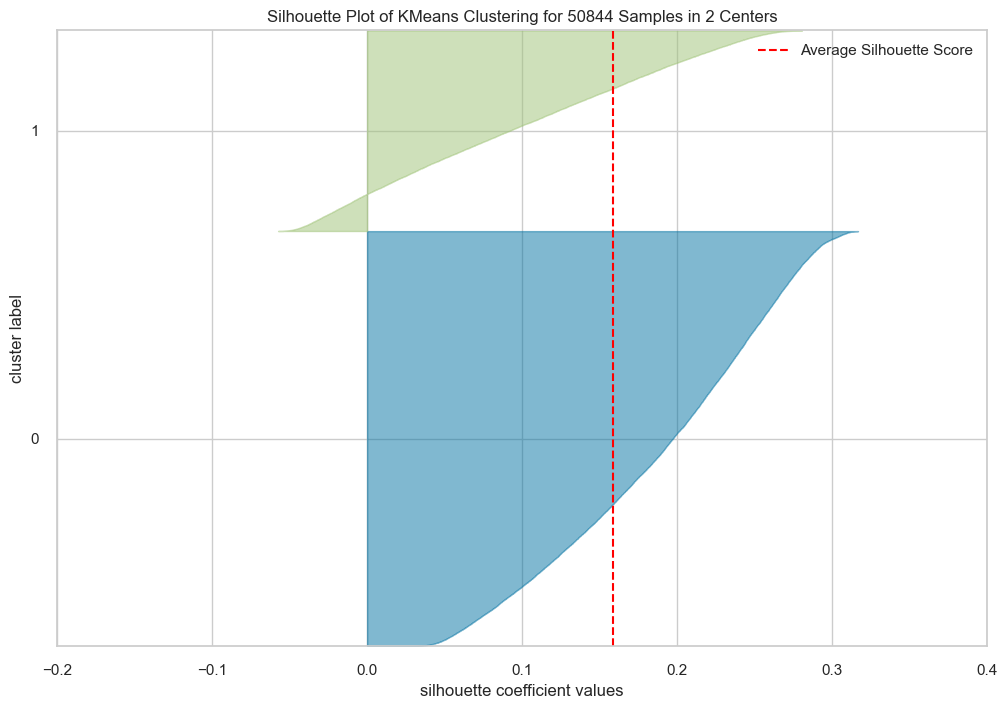

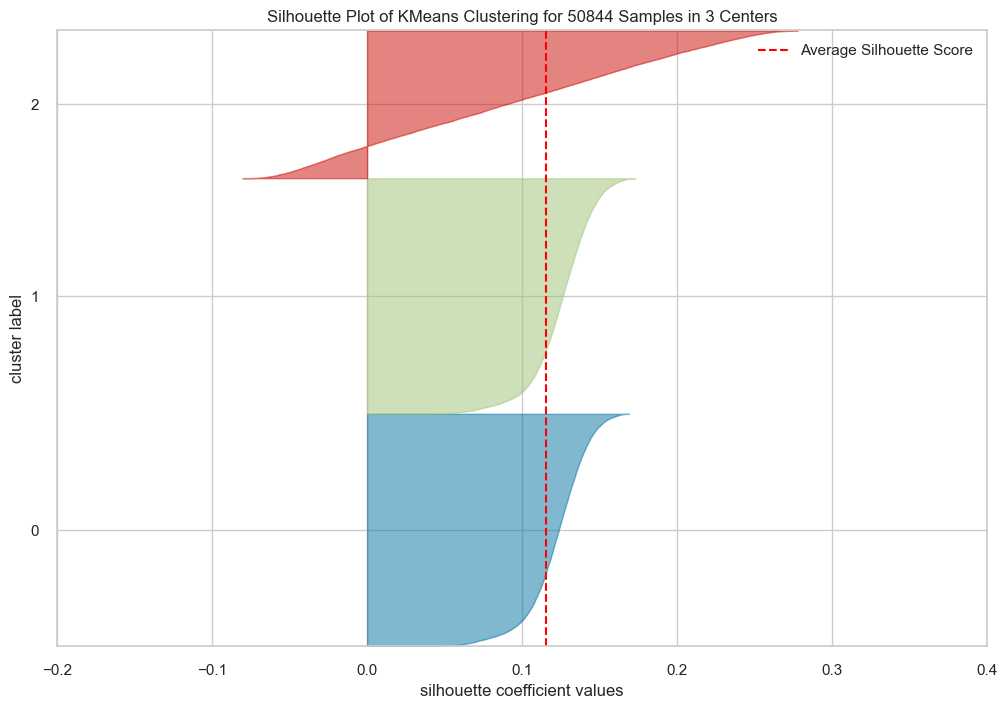

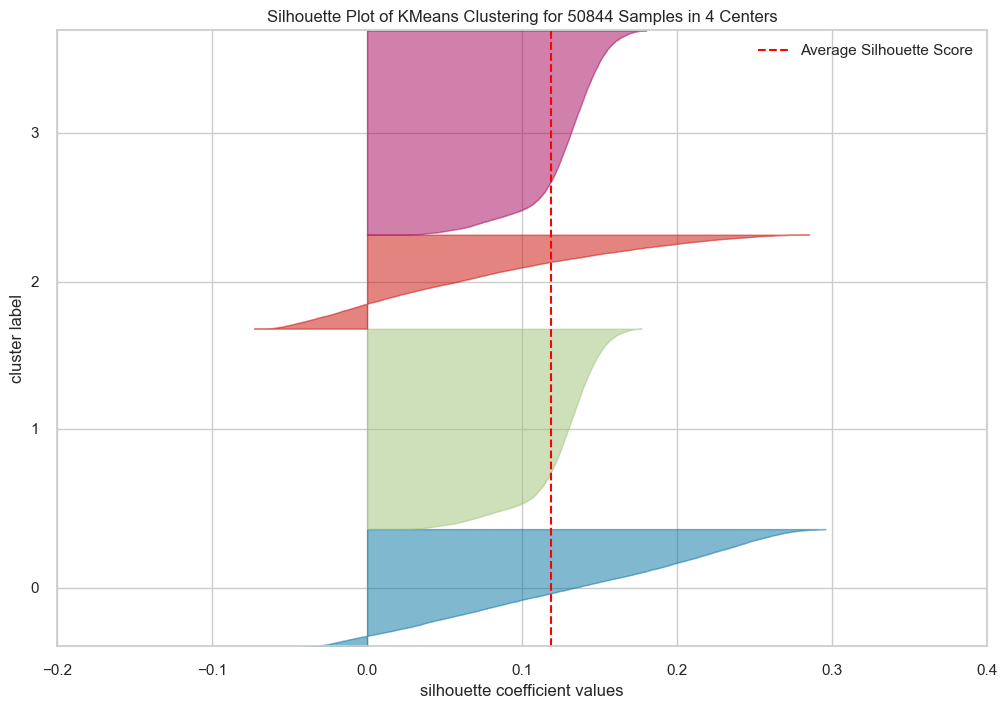

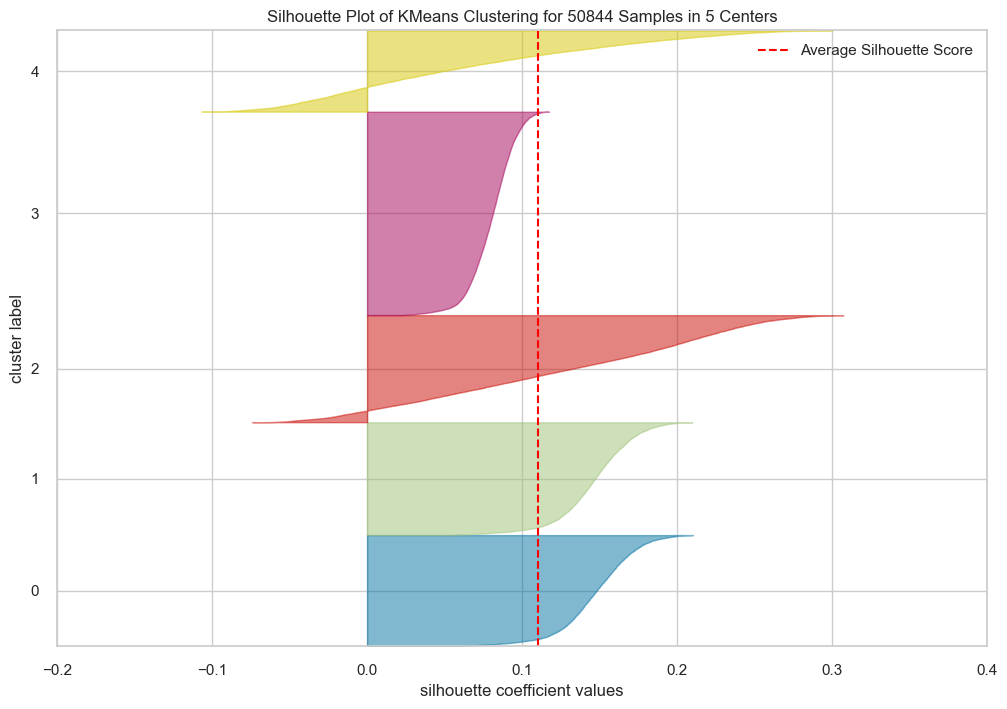

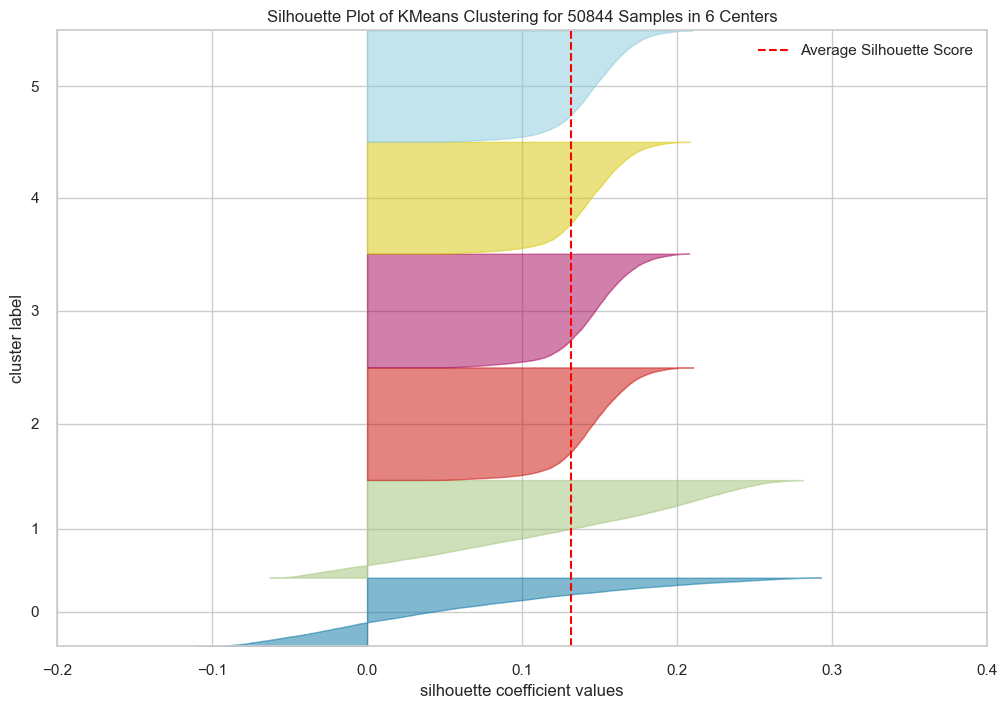

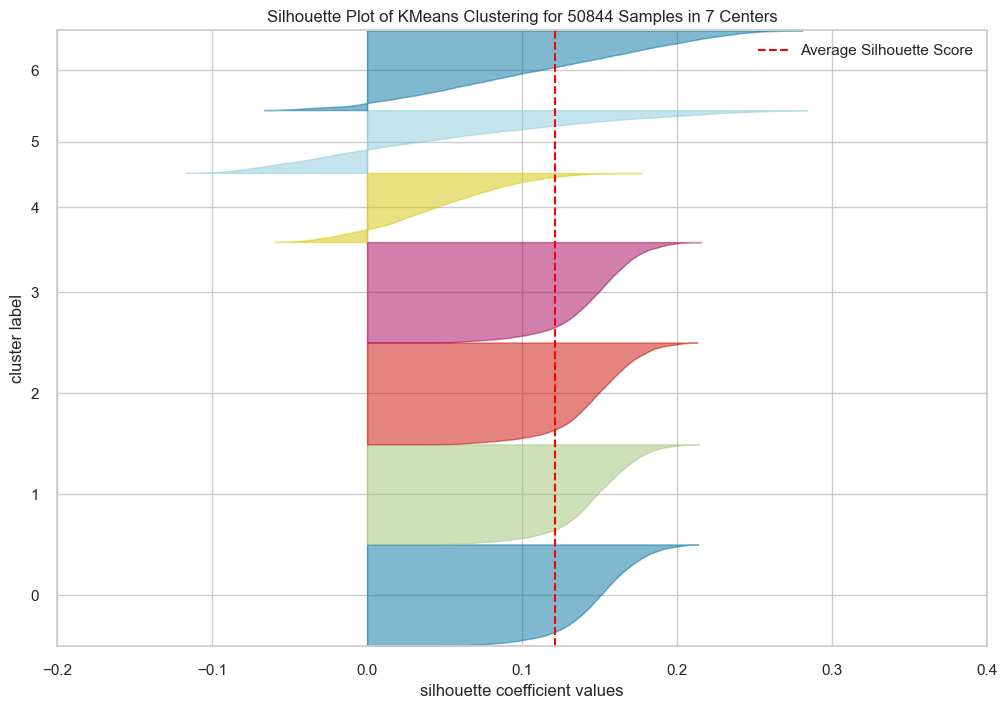

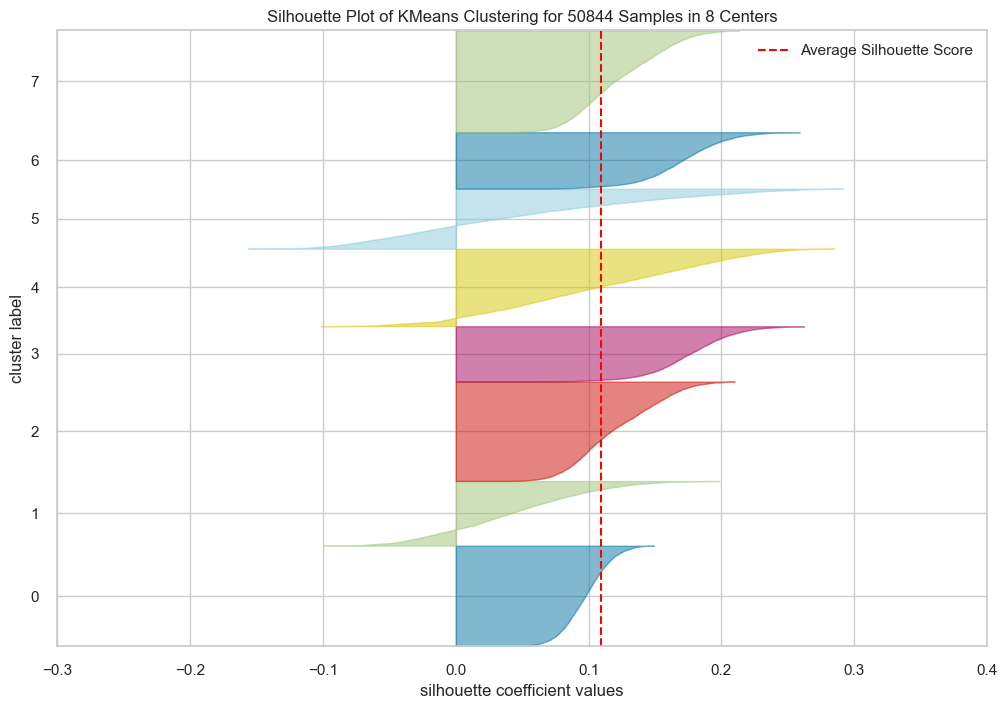

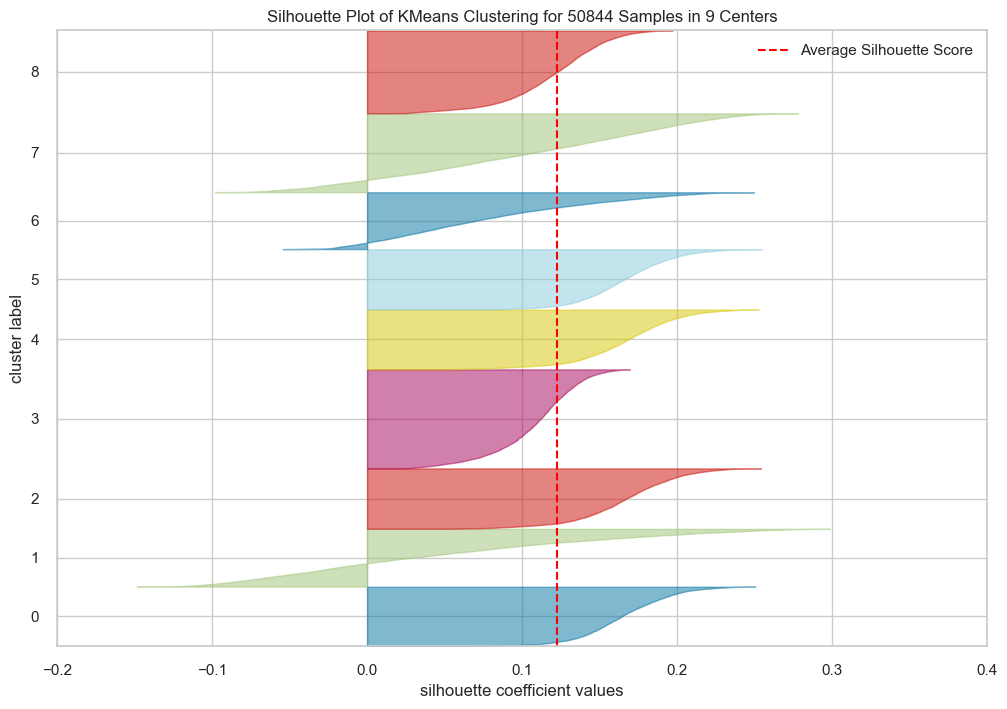

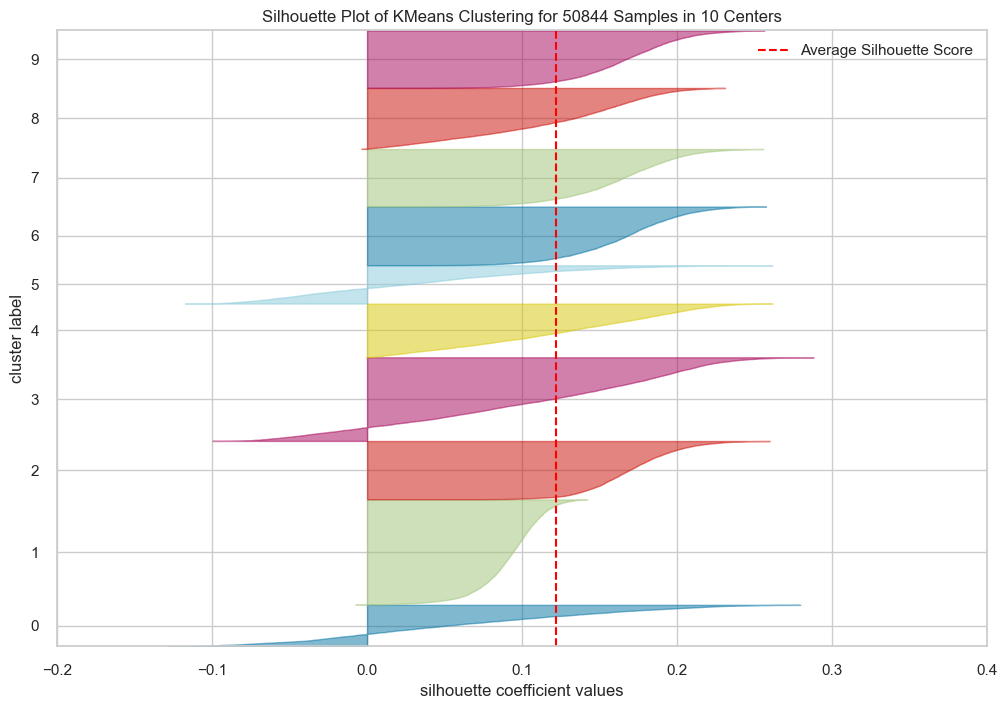

In [15]:
for k in k_range:
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = kmeans.fit_predict(df_scaled)

    sil_visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    sil_visualizer.fit(df_scaled)
    sil_visualizer.show()

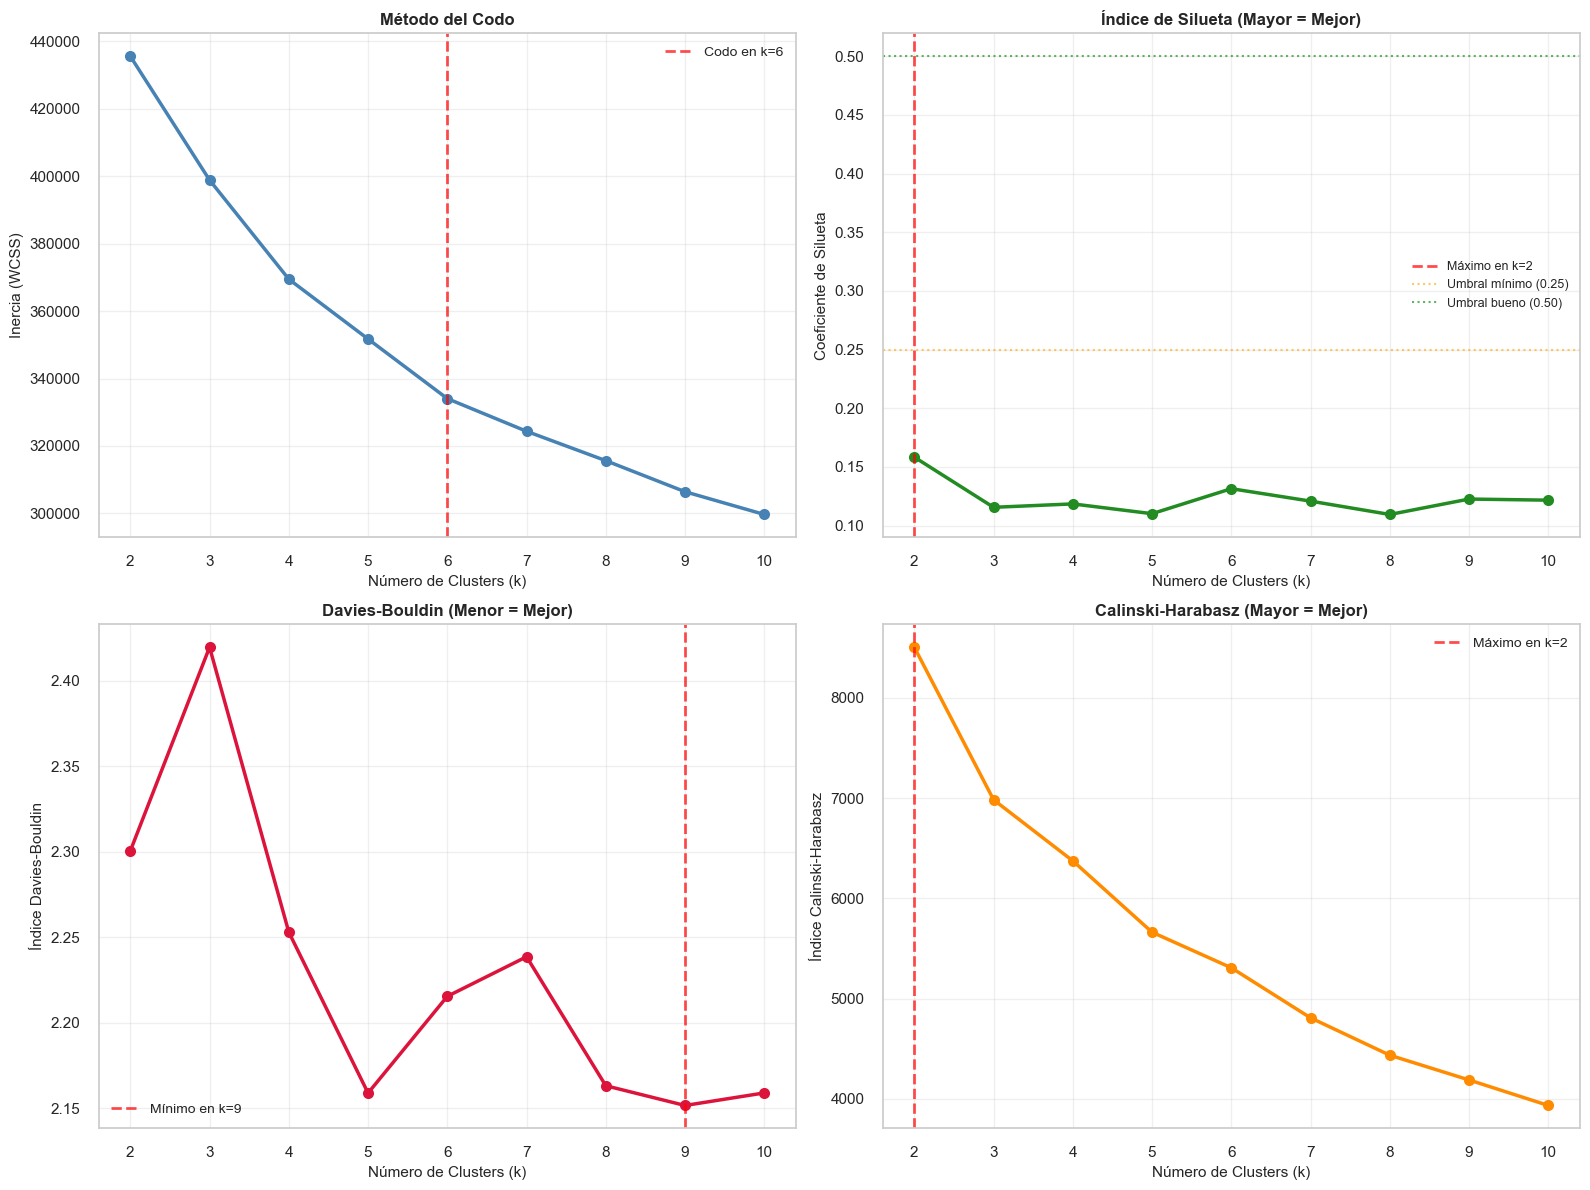

In [16]:
# Visualización comparativa de métricas

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Inercia (Elbow)
axes[0, 0].plot(df_metricas_kmeans['k'], df_metricas_kmeans['Inercia'], 
                'o-', linewidth=2.5, markersize=8, color='steelblue')
if k_elbow:
    axes[0, 0].axvline(x=k_elbow, color='red', linestyle='--', linewidth=2, 
                       label=f'Codo en k={k_elbow}', alpha=0.7)
axes[0, 0].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[0, 0].set_ylabel('Inercia (WCSS)', fontsize=11)
axes[0, 0].set_title('Método del Codo', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(df_metricas_kmeans['k'])
if k_elbow:
    axes[0, 0].legend(fontsize=10)

# Gráfico 2: Silueta (maximizar)
axes[0, 1].plot(df_metricas_kmeans['k'], df_metricas_kmeans['Silueta'], 
                'o-', linewidth=2.5, markersize=8, color='forestgreen')
axes[0, 1].axvline(x=k_mejor_silueta, color='red', linestyle='--', linewidth=2, 
                   label=f'Máximo en k={k_mejor_silueta}', alpha=0.7)
axes[0, 1].axhline(y=0.25, color='orange', linestyle=':', linewidth=1.5, 
                   label='Umbral mínimo (0.25)', alpha=0.6)
axes[0, 1].axhline(y=0.50, color='green', linestyle=':', linewidth=1.5, 
                   label='Umbral bueno (0.50)', alpha=0.6)
axes[0, 1].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[0, 1].set_ylabel('Coeficiente de Silueta', fontsize=11)
axes[0, 1].set_title('Índice de Silueta (Mayor = Mejor)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(df_metricas_kmeans['k'])
axes[0, 1].legend(fontsize=9)

# Gráfico 3: Davies-Bouldin (minimizar)
axes[1, 0].plot(df_metricas_kmeans['k'], df_metricas_kmeans['Davies-Bouldin'], 
                'o-', linewidth=2.5, markersize=8, color='crimson')
axes[1, 0].axvline(x=k_mejor_db, color='red', linestyle='--', linewidth=2, 
                   label=f'Mínimo en k={k_mejor_db}', alpha=0.7)
axes[1, 0].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[1, 0].set_ylabel('Índice Davies-Bouldin', fontsize=11)
axes[1, 0].set_title('Davies-Bouldin (Menor = Mejor)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(df_metricas_kmeans['k'])
axes[1, 0].legend(fontsize=10)

# Gráfico 4: Calinski-Harabasz (maximizar)
axes[1, 1].plot(df_metricas_kmeans['k'], df_metricas_kmeans['Calinski-Harabasz'], 
                'o-', linewidth=2.5, markersize=8, color='darkorange')
axes[1, 1].axvline(x=k_mejor_ch, color='red', linestyle='--', linewidth=2, 
                   label=f'Máximo en k={k_mejor_ch}', alpha=0.7)
axes[1, 1].set_xlabel('Número de Clusters (k)', fontsize=11)
axes[1, 1].set_ylabel('Índice Calinski-Harabasz', fontsize=11)
axes[1, 1].set_title('Calinski-Harabasz (Mayor = Mejor)', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(df_metricas_kmeans['k'])
axes[1, 1].legend(fontsize=10)

plt.tight_layout()
plt.show()

In [17]:
# Selección del número óptimo de clusters

# Determinar k óptimo basado en consenso de métricas
# Priorizar Silueta por su interpretabilidad directa de la calidad del clustering

k_optimo = int(k_mejor_silueta)


print('SELECCIÓN DE NÚMERO ÓPTIMO DE CLUSTERS')

print(f'\nNúmero de clusters seleccionado: k = {k_optimo}')
print('\nJustificación:')
print(f'  - Método del Codo: k = {k_elbow if k_elbow else "No definido"}')
print(f'  - Mejor Silueta: k = {k_mejor_silueta}')
print(f'  - Mejor Davies-Bouldin: k = {k_mejor_db}')
print(f'  - Mejor Calinski-Harabasz: k = {k_mejor_ch}')
print('\nCriterio de selección: Maximización del Coeficiente de Silueta')
print('Razón: Mejor balance entre cohesión intra-cluster y separación inter-cluster')

SELECCIÓN DE NÚMERO ÓPTIMO DE CLUSTERS

Número de clusters seleccionado: k = 2

Justificación:
  - Método del Codo: k = 6
  - Mejor Silueta: k = 2
  - Mejor Davies-Bouldin: k = 9
  - Mejor Calinski-Harabasz: k = 2

Criterio de selección: Maximización del Coeficiente de Silueta
Razón: Mejor balance entre cohesión intra-cluster y separación inter-cluster


### 7.2 Modelo K-Means Final

Basándonos en el análisis multi-criterio, se selecciona **k=2** como solución óptima. Esta decisión se fundamenta en:

1. **Máximo Calinski-Harabasz**: Indica la mejor relación dispersión inter/intra-cluster
2. **Interpretabilidad actuarial**: Dos segmentos (bajo/alto riesgo) facilitan estrategias de tarificación diferenciada
3. **Diferencial de riesgo significativo**: Separación clara en tasas de impago entre clusters

Aunque k=3 o k=4 podrían ofrecer segmentaciones más granulares, el análisis de perfiles reveló que clusters adicionales no aportan diferenciación sustancial en las variables de riesgo clave.

In [18]:
# Entrenar modelo K-Means final con k óptimo

kmeans_final = KMeans(
    n_clusters=k_optimo, 
    random_state=42, 
    n_init=50,      # Aumentar inicializaciones para mejor convergencia
    max_iter=1000,  # Aumentar iteraciones máximas
    algorithm='lloyd'  # Algoritmo estándar de K-Means
)

labels_kmeans = kmeans_final.fit_predict(df_scaled)

# Añadir etiquetas al dataset original
df_original['Cluster_KMeans'] = labels_kmeans

# Calcular métricas finales
sil_final = silhouette_score(df_scaled, labels_kmeans)
db_final = davies_bouldin_score(df_scaled, labels_kmeans)
ch_final = calinski_harabasz_score(df_scaled, labels_kmeans)

print('MODELO K-MEANS FINAL')

print(f'\nParámetros del modelo:')
print(f'  Número de clusters: {k_optimo}')
print(f'  Inicializaciones: {kmeans_final.n_init}')
print(f'  Iteraciones hasta convergencia: {kmeans_final.n_iter_}')
print(f'  Inercia final: {kmeans_final.inertia_:.2f}')

print(f'\nMétricas de calidad:')
print(f'  Coeficiente de Silueta: {sil_final:.4f}')
print(f'  Índice Davies-Bouldin: {db_final:.4f}')
print(f'  Índice Calinski-Harabasz: {ch_final:.2f}')

print(f'\nDistribución de observaciones por cluster:')
cluster_sizes = pd.Series(labels_kmeans).value_counts().sort_index()
for cluster_id in range(k_optimo):
    count = cluster_sizes[cluster_id]
    pct = (count / len(labels_kmeans)) * 100
    print(f'  Cluster {cluster_id}: {count:>6,} observaciones ({pct:>5.2f}%)')

print(f'\nTotal: {len(labels_kmeans):,} observaciones')

MODELO K-MEANS FINAL

Parámetros del modelo:
  Número de clusters: 2
  Inicializaciones: 50
  Iteraciones hasta convergencia: 14
  Inercia final: 435567.21

Métricas de calidad:
  Coeficiente de Silueta: 0.1585
  Índice Davies-Bouldin: 2.2995
  Índice Calinski-Harabasz: 8506.18

Distribución de observaciones por cluster:
  Cluster 0: 34,310 observaciones (67.48%)
  Cluster 1: 16,534 observaciones (32.52%)

Total: 50,844 observaciones


### 7.3 Visualización de Clusters en Espacio PCA

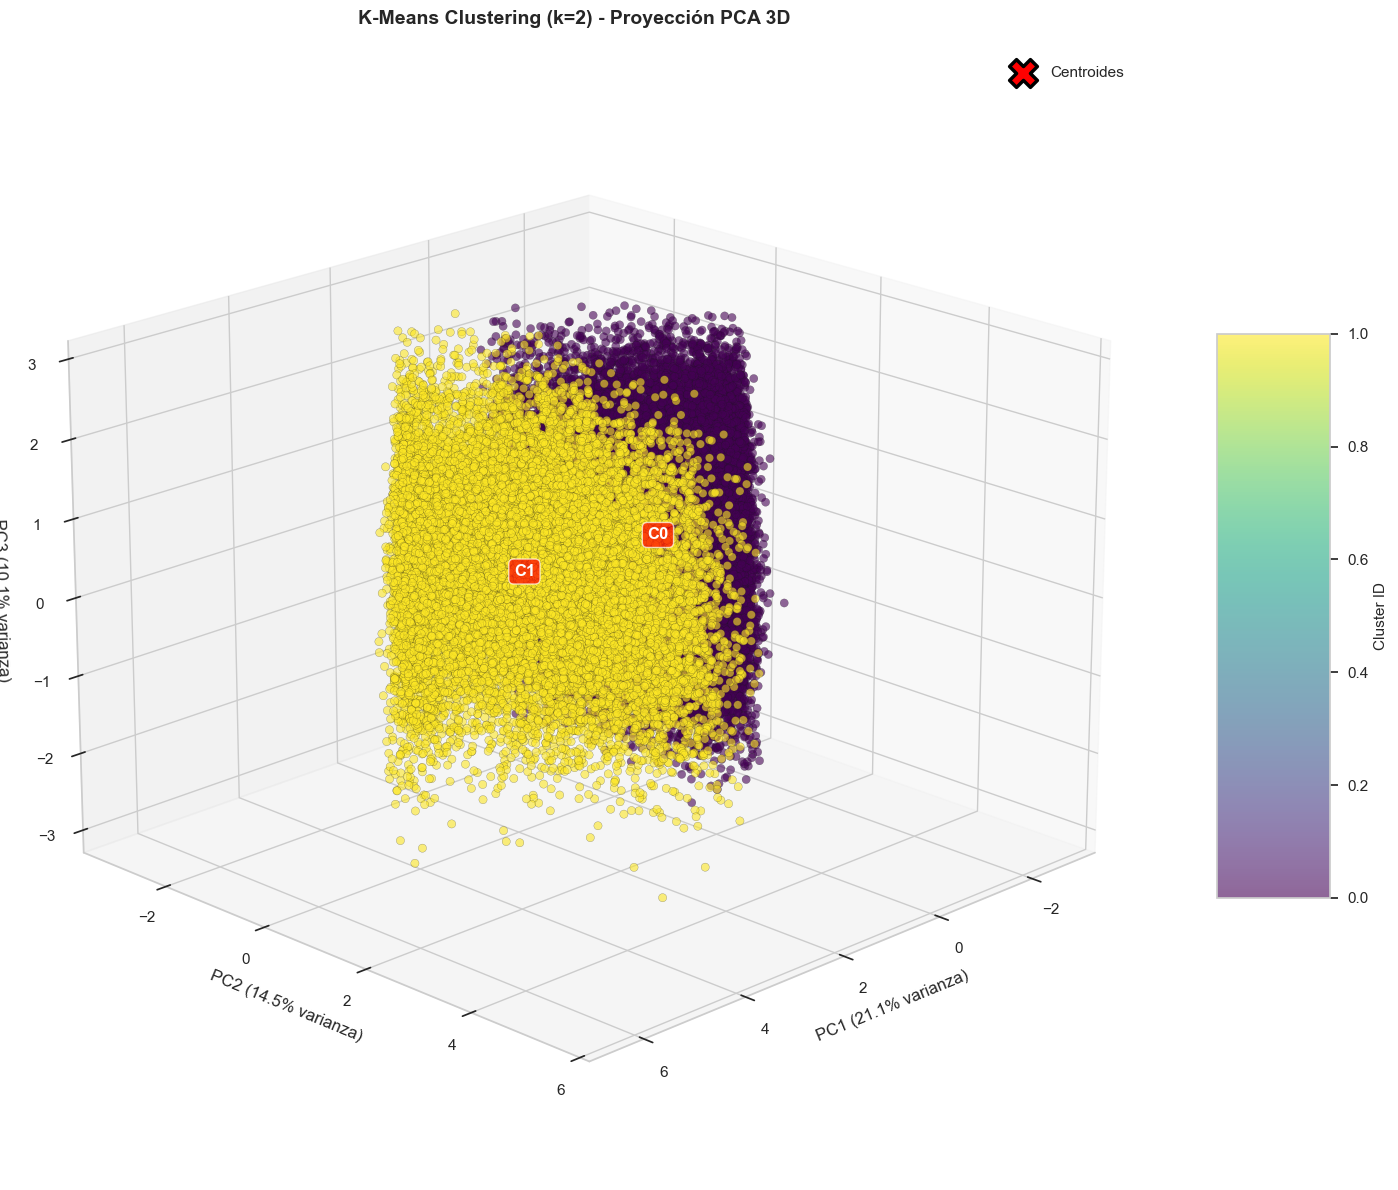

NOTA:
La visualización es una proyección 3D que captura 45.7% de la varianza total.
El clustering se realizó en el espacio completo de 9 dimensiones.

Puedes rotar el gráfico interactivamente si usas un entorno compatible (Jupyter, etc.)


In [19]:
# Proyectar centroides al espacio PCA
centroides_pca = pca_3d.transform(kmeans_final.cluster_centers_)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot de observaciones coloreadas por cluster
scatter = ax.scatter(df_pca_3d[:, 0], df_pca_3d[:, 1], df_pca_3d[:, 2],
                     c=labels_kmeans, cmap='viridis', 
                     alpha=0.6, s=35, edgecolors='k', linewidth=0.2)

# Plot de centroides
ax.scatter(centroides_pca[:, 0], centroides_pca[:, 1], centroides_pca[:, 2],
           c='red', marker='X', s=400, edgecolors='black', linewidth=2.5,
           label='Centroides', zorder=10)

# Anotar centroides
for i, (x, y, z) in enumerate(centroides_pca):
    ax.text(x, y, z, f'C{i}', fontsize=12, fontweight='bold',
            ha='center', va='center', color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7))

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)

ax.set_title(f'K-Means Clustering (k={k_optimo}) - Proyección PCA 3D', 
             fontweight='bold', fontsize=14, pad=20)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Cluster ID', fontsize=11)

ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

# Ajustar ángulo de visualización para mejor perspectiva
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print('NOTA:')
print('La visualización es una proyección 3D que captura', end=' ')
print(f'{pca_3d.explained_variance_ratio_.sum()*100:.1f}% de la varianza total.')
print('El clustering se realizó en el espacio completo de 9 dimensiones.')
print('\nPuedes rotar el gráfico interactivamente si usas un entorno compatible (Jupyter, etc.)')

### 7.4 Análisis de Silueta por Cluster

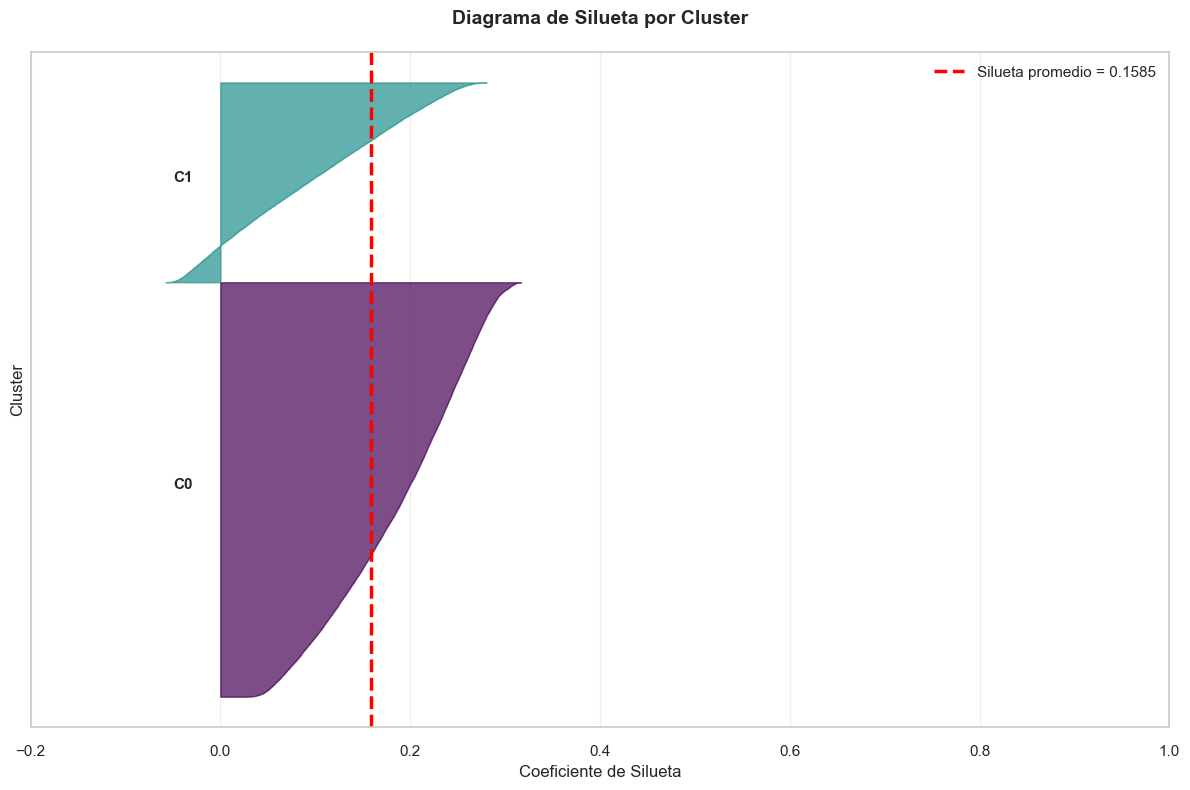

ESTADÍSTICAS DE SILUETA POR CLUSTER
 Cluster   |    Media     |   Mediana    |     Std      |     Min      |     Max     
--------------------------------------------------------------------------------
    0      |    0.1885    |    0.1972    |    0.0704    |    0.0246    |    0.3167   
    1      |    0.0963    |    0.0922    |    0.0886    |   -0.0577    |    0.2805   
  Global   |    0.1585    |      -       |      -       |      -       |      -      

INTERPRETACIÓN:
  - Clusters con silueta promedio > 0.25 tienen estructura razonable
  - Valores negativos indican posibles asignaciones incorrectas
  - Alta variabilidad sugiere heterogeneidad dentro del cluster


In [20]:
# Diagrama de silueta detallado

fig, ax = plt.subplots(figsize=(12, 8))

# Calcular valores de silueta por observación
silhouette_vals = silhouette_samples(df_scaled, labels_kmeans)

y_lower = 10
for i in range(k_optimo):
    # Valores de silueta para cluster i
    cluster_silhouette_vals = silhouette_vals[labels_kmeans == i]
    cluster_silhouette_vals.sort()
    
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    
    color = cm.viridis(float(i) / k_optimo)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                    facecolor=color, edgecolor=color, alpha=0.7)
    
    # Etiqueta del cluster
    ax.text(-0.05, y_lower + 0.5 * size_cluster, f'C{i}', 
           fontsize=11, fontweight='bold')
    
    y_lower = y_upper + 10

# Línea vertical del promedio
ax.axvline(x=sil_final, color='red', linestyle='--', linewidth=2.5, 
          label=f'Silueta promedio = {sil_final:.4f}')

ax.set_xlabel('Coeficiente de Silueta', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Diagrama de Silueta por Cluster', fontweight='bold', fontsize=14, pad=20)
ax.set_yticks([])
ax.set_xlim([-0.2, 1])
ax.legend(loc='best', fontsize=11)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas de silueta por cluster

print('ESTADÍSTICAS DE SILUETA POR CLUSTER')

print(f"{'Cluster':^10} | {'Media':^12} | {'Mediana':^12} | {'Std':^12} | {'Min':^12} | {'Max':^12}")
print('-'*80)

for i in range(k_optimo):
    cluster_sil = silhouette_vals[labels_kmeans == i]
    print(f"{i:^10} | {cluster_sil.mean():^12.4f} | {np.median(cluster_sil):^12.4f} | "
          f"{cluster_sil.std():^12.4f} | {cluster_sil.min():^12.4f} | {cluster_sil.max():^12.4f}")


print(f"{'Global':^10} | {sil_final:^12.4f} | {'-':^12} | {'-':^12} | {'-':^12} | {'-':^12}")


print('\nINTERPRETACIÓN:')
print('  - Clusters con silueta promedio > 0.25 tienen estructura razonable')
print('  - Valores negativos indican posibles asignaciones incorrectas')
print('  - Alta variabilidad sugiere heterogeneidad dentro del cluster')

### 7.5 Perfilado de Clusters

El perfilado caracteriza cada cluster en función de las variables de segmentación, permitiendo:

1. **Interpretación de negocio**: Traducir patrones matemáticos a perfiles de prestatarios
2. **Validación de coherencia**: Verificar que los clusters capturan diferencias sustantivas, no artefactos estadísticos
3. **Base para tarificación**: Fundamentar estrategias de pricing diferenciado del seguro

Se utilizan tanto medias (sensibles a outliers pero interpretables) como medianas (robustas a valores extremos) para una caracterización completa.

In [21]:
# Análisis estadístico por cluster

# Calcular estadísticas descriptivas por cluster
perfiles_kmeans = df_original.groupby('Cluster_KMeans')[variables_clustering].agg(['mean', 'median', 'std'])


print('PERFIL ESTADÍSTICO POR CLUSTER - K-MEANS')

print('\nMEDIAS POR CLUSTER:')
display(perfiles_kmeans.xs('mean', axis=1, level=1))

print('\nMEDIANAS POR CLUSTER:')
display(perfiles_kmeans.xs('median', axis=1, level=1))

print('\nDESVIACIONES ESTÁNDAR POR CLUSTER:')
display(perfiles_kmeans.xs('std', axis=1, level=1))

PERFIL ESTADÍSTICO POR CLUSTER - K-MEANS

MEDIAS POR CLUSTER:


Ingresos  Monto_Inicial  Scoring_Crediticio  Ratio_Interes  \
Cluster_KMeans                                                                
0              37451.4538     14029.1373            531.2676        13.4195   
1              50137.7927     32255.3416            664.4458        13.5662   

                Duracion  Ratio_Deuda_Ingresos  Num_Creditos  \
Cluster_KMeans                                                 
0                41.2466                0.1380        2.4959   
1                25.1257                0.3551        2.4968   

                Posesion_Hipoteca  Personas_Cargo  Fiador  
Cluster_KMeans                                             
0                          0.5024          0.5021  0.5046  
1                          0.5052          0.4982  0.5003


MEDIANAS POR CLUSTER:


Ingresos  Monto_Inicial  Scoring_Crediticio  Ratio_Interes  \
Cluster_KMeans                                                                
0              36038.5000     12586.5000            513.0000        13.3700   
1              47202.5000     29692.5000            689.0000        13.5300   

                Duracion  Ratio_Deuda_Ingresos  Num_Creditos  \
Cluster_KMeans                                                 
0                48.0000                0.1100        2.0000   
1                24.0000                0.3400        2.0000   

                Posesion_Hipoteca  Personas_Cargo  Fiador  
Cluster_KMeans                                             
0                          1.0000          1.0000  1.0000  
1                          1.0000          0.0000  1.0000


DESVIACIONES ESTÁNDAR POR CLUSTER:


Ingresos  Monto_Inicial  Scoring_Crediticio  Ratio_Interes  \
Cluster_KMeans                                                                
0              13691.3796      7721.0707            151.9163         6.6472   
1              17195.8925     15058.1021            134.2167         6.6078   

                Duracion  Ratio_Deuda_Ingresos  Num_Creditos  \
Cluster_KMeans                                                 
0                15.4578                0.0549        1.1208   
1                14.7620                0.1386        1.1175   

                Posesion_Hipoteca  Personas_Cargo  Fiador  
Cluster_KMeans                                             
0                          0.5000          0.5000  0.5000  
1                          0.5000          0.5000  0.5000

### 7.6 Validación con Variable Objetivo

Aunque la variable **Impago** no se utilizó en el proceso de clustering (para evitar data leakage), su análisis *post-hoc* permite:

1. **Validar la utilidad del clustering**: Verificar si los clusters capturan perfiles de riesgo diferenciados
2. **Cuantificar el diferencial de riesgo**: Calcular métricas actuariales (Odds Ratio, Riesgo Relativo)
3. **Justificar tarificación diferenciada**: Fundamentar primas de seguro distintas por cluster

**Nota crítica**: Una asociación moderada (ARI/NMI < 0.3) confirma que el clustering NO está contaminado por la variable objetivo, validando la ausencia de data leakage.

ANÁLISIS DE RIESGO POR CLUSTER


N_Impagos  Tasa_Impago  N_Total
Cluster_KMeans                                 
0                    4446       0.1296    34310
1                    1595       0.0965    16534

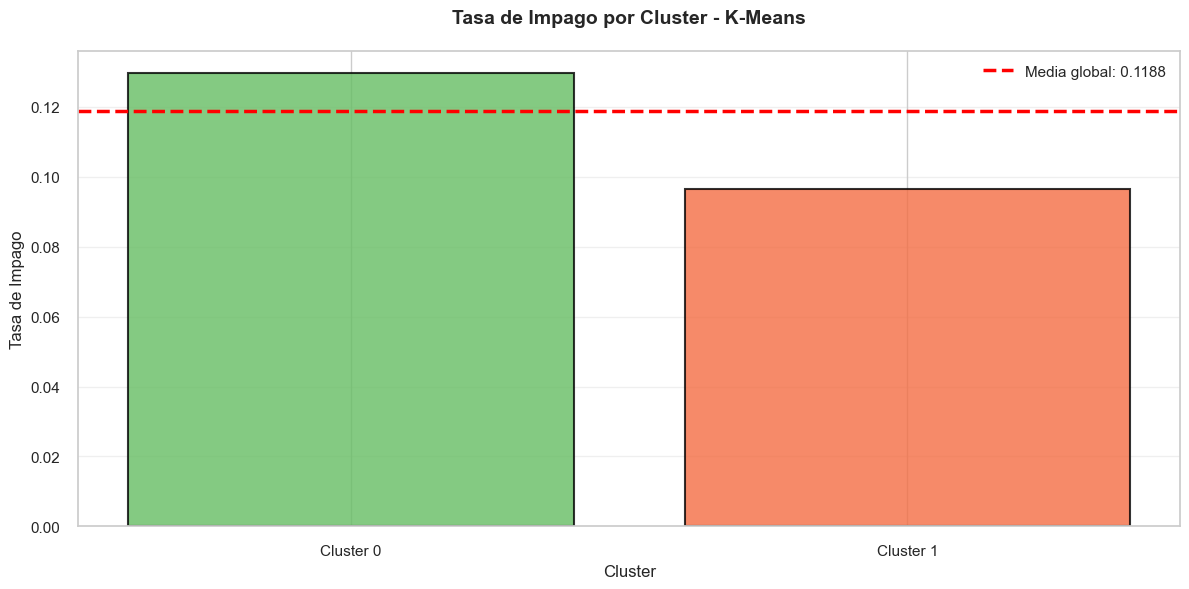


CLASIFICACIÓN DE CLUSTERS POR NIVEL DE RIESGO:
  Cluster 0: MEDIO    (Tasa = 0.1296)
  Cluster 1: BAJO     (Tasa = 0.0965)


In [22]:
# Análisis de riesgo por cluster (usando variable Impago)
print('ANÁLISIS DE RIESGO POR CLUSTER')


analisis_riesgo = df_original.groupby('Cluster_KMeans').agg({
    'Impago': ['sum', 'mean', 'count']
})

analisis_riesgo.columns = ['N_Impagos', 'Tasa_Impago', 'N_Total']
analisis_riesgo = analisis_riesgo.sort_values('Tasa_Impago', ascending=False)

display(analisis_riesgo)

# Visualización de tasa de impago por cluster
plt.figure(figsize=(12, 6))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, k_optimo))
bars = plt.bar(range(k_optimo), 
              [analisis_riesgo.loc[i, 'Tasa_Impago'] for i in range(k_optimo)],
              color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Línea de referencia con media global
plt.axhline(y=df_original['Impago'].mean(), color='red', linestyle='--', 
           linewidth=2.5, label=f'Media global: {df_original["Impago"].mean():.4f}')

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Tasa de Impago', fontsize=12)
plt.title('Tasa de Impago por Cluster - K-Means', fontweight='bold', fontsize=14, pad=20)
plt.xticks(range(k_optimo), [f'Cluster {i}' for i in range(k_optimo)])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\nCLASIFICACIÓN DE CLUSTERS POR NIVEL DE RIESGO:')
for i, row in analisis_riesgo.iterrows():
    tasa = row['Tasa_Impago']
    if tasa > df_original['Impago'].mean() * 1.1:
        nivel = 'ALTO'
    elif tasa < df_original['Impago'].mean() * 0.9:
        nivel = 'BAJO'
    else:
        nivel = 'MEDIO'
    print(f'  Cluster {i}: {nivel:8s} (Tasa = {tasa:.4f})')

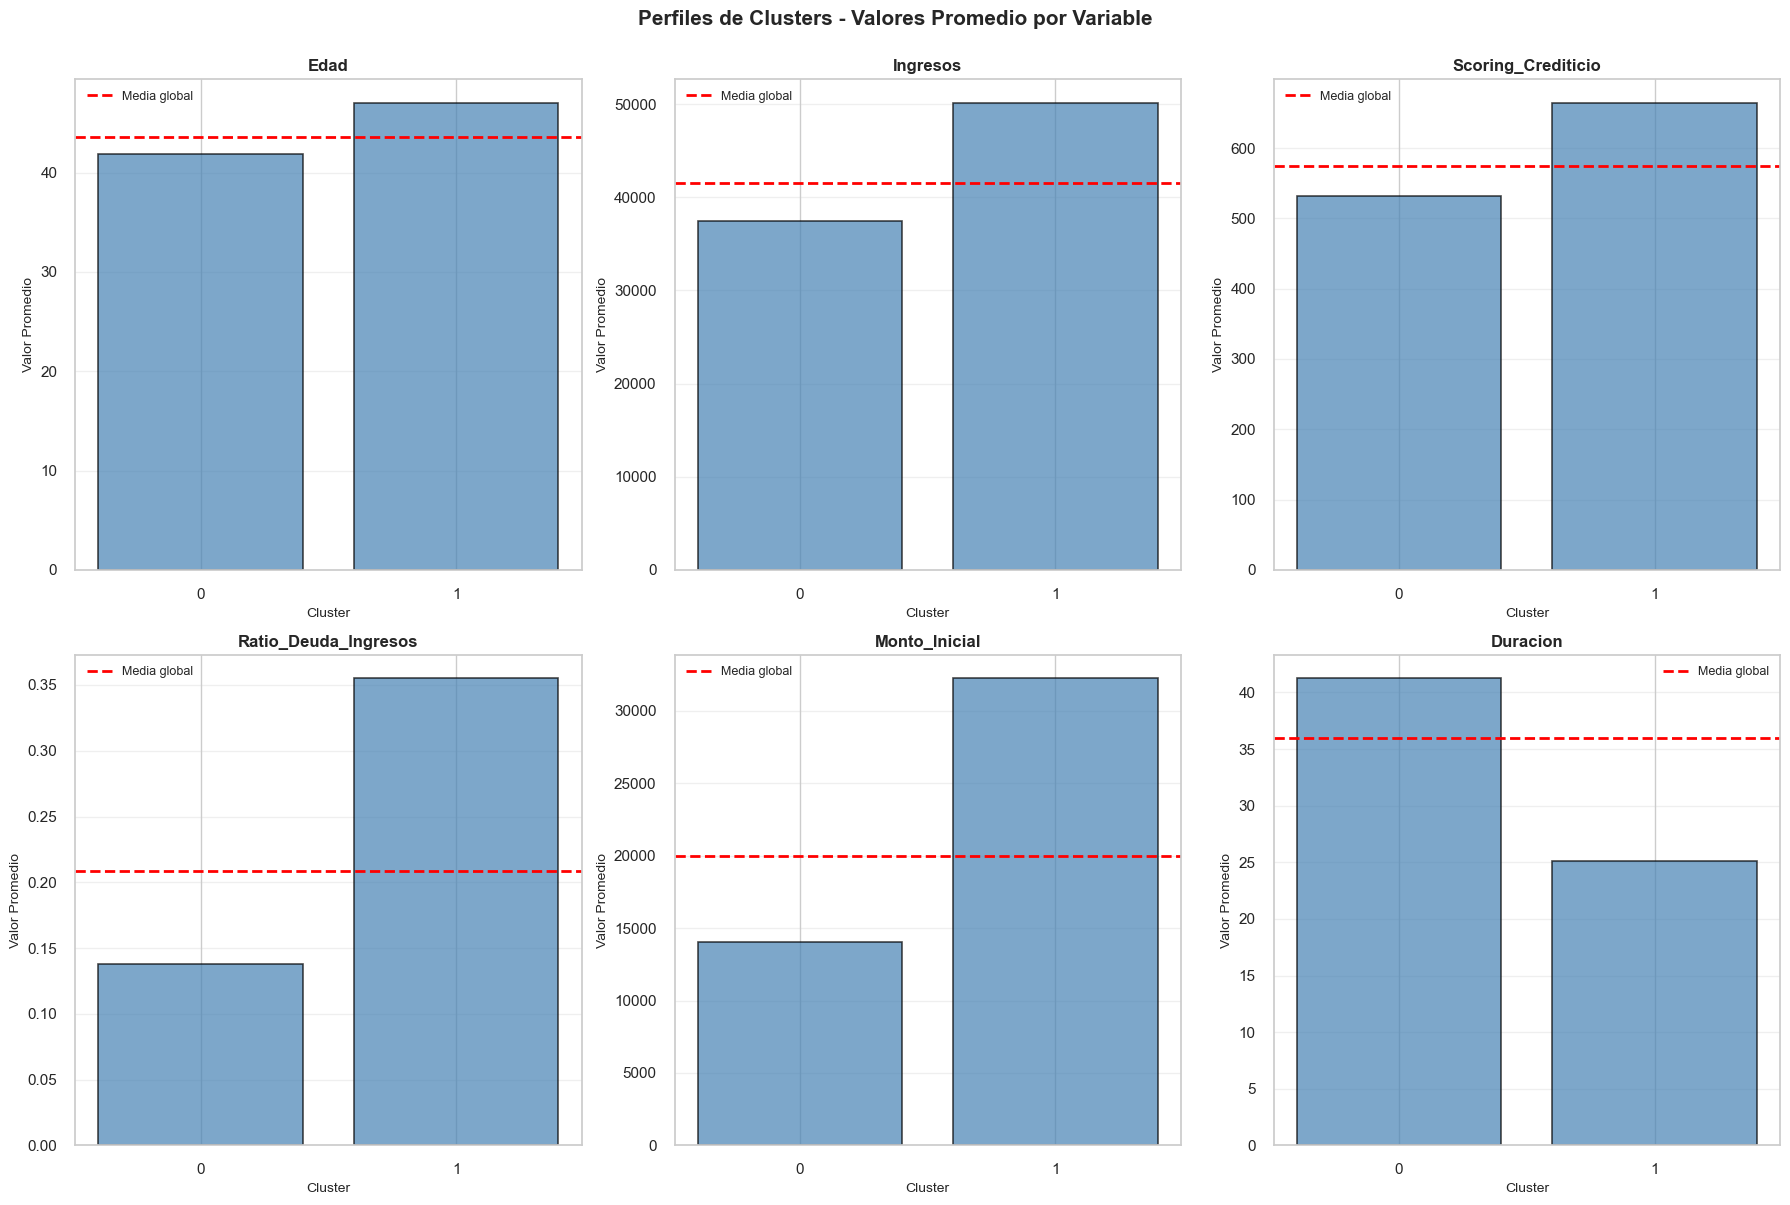

In [23]:
# Visualización de perfiles por variable

# Seleccionar variables clave para visualización
vars_viz = ['Edad', 'Ingresos', 'Scoring_Crediticio', 'Ratio_Deuda_Ingresos',
            'Monto_Inicial', 'Duracion']


fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

medias_globales = df_original[vars_viz].mean()

for idx, var in enumerate(vars_viz):
    # Extraer medias por cluster
    medias_cluster = [df_original[df_original['Cluster_KMeans']==i][var].mean() 
                     for i in range(k_optimo)]
    
    # Crear gráfico de barras
    axes[idx].bar(range(k_optimo), medias_cluster, 
                 color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.2)
    axes[idx].axhline(y=medias_globales[var], color='red', linestyle='--', 
                     linewidth=2, label='Media global')
    axes[idx].set_title(var, fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Cluster', fontsize=10)
    axes[idx].set_ylabel('Valor Promedio', fontsize=10)
    axes[idx].set_xticks(range(k_optimo))
    axes[idx].legend(fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Perfiles de Clusters - Valores Promedio por Variable', 
            fontweight='bold', fontsize=15, y=1.00)
plt.tight_layout()
plt.show()

## 8. Clustering Jerárquico Aglomerativo

### 8.1 Comparación de Métodos de Enlace

**Métodos de enlace evaluados:**

1. **Ward**: Minimiza la varianza dentro de los clusters (recomendado para datos cuantitativos)
2. **Complete** (enlace completo): Distancia máxima entre puntos de diferentes clusters
3. **Average** (enlace promedio): Distancia promedio entre todos los pares de puntos
4. **Single** (enlace simple): Distancia mínima entre puntos (propenso a chaining effect)

**Nota metodológica:**

El método Single suele generar siluetas artificialmente altas debido al efecto de encadenamiento (chaining), donde clusters se forman por proximidad local sin cohesión global. Por tanto, no se recomienda para aplicaciones de negocio.

In [24]:
# Evaluación de métodos de enlace

linkage_methods = ['ward', 'complete', 'average', 'single']
resultados_jerarquico = {}


print(f'EVALUACIÓN DE MÉTODOS DE ENLACE - CLUSTERING JERÁRQUICO (k={k_optimo})')

print(f"{'Método':^15} | {'Silueta':^12} | {'Davies-Bouldin':^18} | {'Calinski-Harabasz':^20}")
print('-'*100)

for method in linkage_methods:
    # Entrenar modelo
    agg = AgglomerativeClustering(n_clusters=k_optimo, linkage=method)
    labels_agg = agg.fit_predict(df_scaled)
    
    # Calcular métricas
    sil = silhouette_score(df_scaled, labels_agg)
    db = davies_bouldin_score(df_scaled, labels_agg)
    ch = calinski_harabasz_score(df_scaled, labels_agg)
    
    resultados_jerarquico[method] = {
        'Silueta': sil,
        'Davies-Bouldin': db,
        'Calinski-Harabasz': ch,
        'labels': labels_agg
    }
    
    print(f"{method:^15} | {sil:^12.4f} | {db:^18.4f} | {ch:^20.2f}")



# Identificar mejor método (excluyendo single por chaining effect)
metodos_validos = {k: v for k, v in resultados_jerarquico.items() if k != 'single'}
# mejor_metodo = max(metodos_validos.items(), key=lambda x: x[1]['Silueta'])[0]
mejor_metodo="ward"

print(f'\nMejor método recomendado (excluyendo Single y Average): {mejor_metodo.upper()}')
print(f'  Silueta: {resultados_jerarquico[mejor_metodo]["Silueta"]:.4f}')
print(f'\nNOTA: El método "single" y "average" se excluye de la recomendación debido al')
print('chaining effect que produce siluetas artificialmente altas pero clusters poco cohesivos.')

EVALUACIÓN DE MÉTODOS DE ENLACE - CLUSTERING JERÁRQUICO (k=2)
    Método      |   Silueta    |   Davies-Bouldin   |  Calinski-Harabasz  
----------------------------------------------------------------------------------------------------
     ward       |    0.1728    |       2.1721       |       5689.89       
   complete     |    0.1963    |       1.8800       |       3056.77       
    average     |    0.2386    |       1.6288       |       2062.80       
    single      |    0.4225    |       0.4323       |         5.16        

Mejor método recomendado (excluyendo Single y Average): WARD
  Silueta: 0.1728

NOTA: El método "single" y "average" se excluye de la recomendación debido al
chaining effect que produce siluetas artificialmente altas pero clusters poco cohesivos.


### 8.2 Dendrograma del Método Seleccionado

Utilizando muestra de 5,000 observaciones para dendrograma


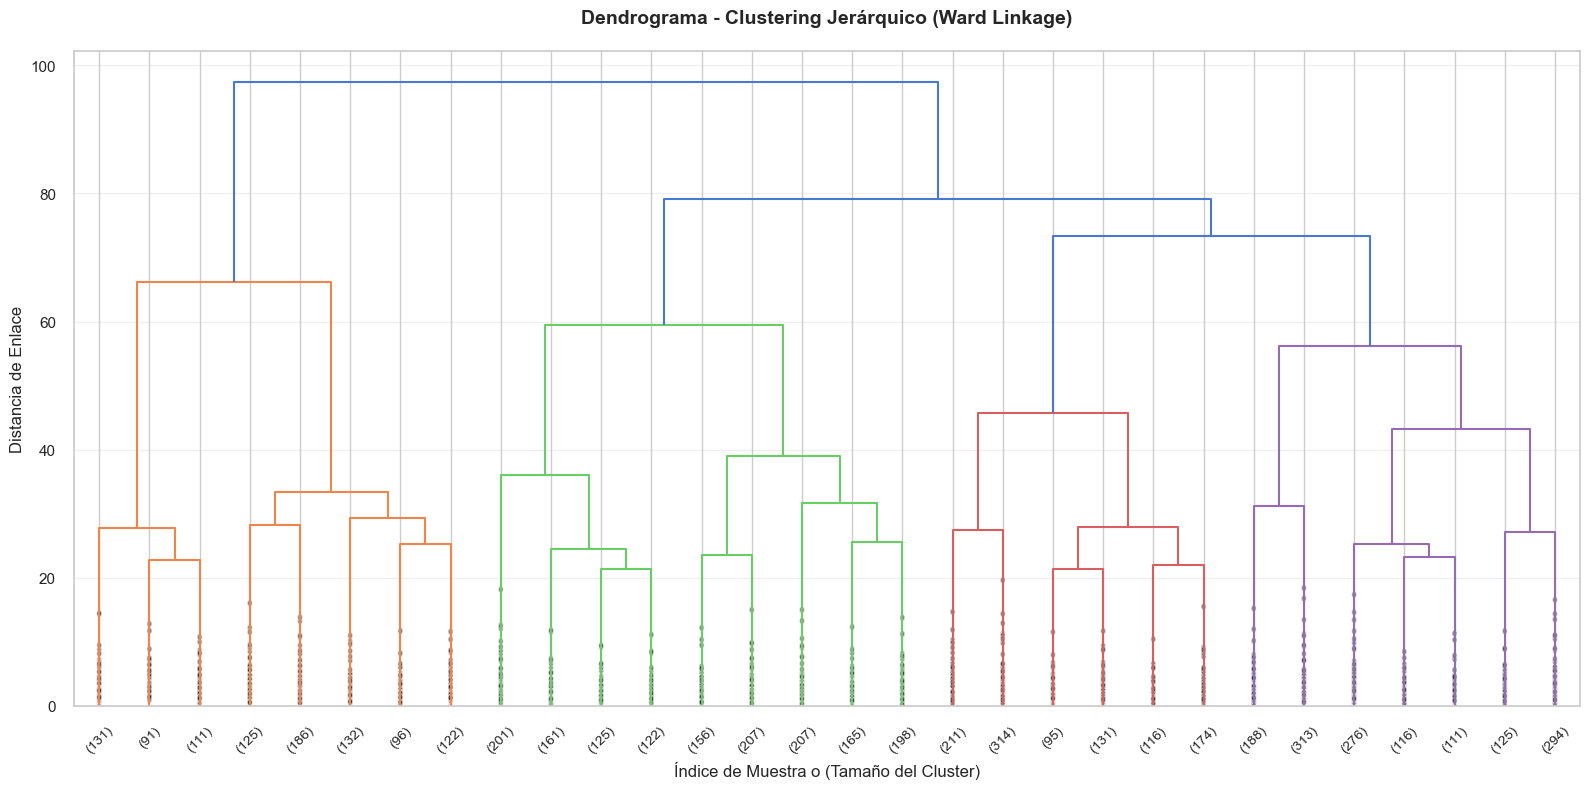


INTERPRETACIÓN DEL DENDROGRAMA:
  - Altura de las fusiones indica la disimilaridad entre clusters
  - Fusiones a mayor altura sugieren clusters menos similares
  - Cortes horizontales a diferentes alturas generan diferentes números de clusters


In [25]:
# Generar dendrograma para el mejor método

# Calcular matriz de enlace usando scipy
# Usar muestra si el dataset es muy grande (>5000 observaciones)
max_samples_dendro = 5000
if len(df_scaled) > max_samples_dendro:
    np.random.seed(42)
    sample_idx = np.random.choice(len(df_scaled), max_samples_dendro, replace=False)
    df_sample = df_scaled.iloc[sample_idx]
    print(f'Utilizando muestra de {max_samples_dendro:,} observaciones para dendrograma')
else:
    df_sample = df_scaled
    print(f'Utilizando dataset completo ({len(df_scaled):,} observaciones) para dendrograma')

# Calcular linkage
linkage_matrix = linkage(df_sample, method=mejor_metodo)

# Crear dendrograma
plt.figure(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',  # Mostrar solo últimas p fusiones
    p=30,                   # Número de fusiones a mostrar
    leaf_font_size=10,
    show_contracted=True
)
plt.title(f'Dendrograma - Clustering Jerárquico ({mejor_metodo.capitalize()} Linkage)', 
         fontweight='bold', fontsize=14, pad=20)
plt.xlabel('Índice de Muestra o (Tamaño del Cluster)', fontsize=12)
plt.ylabel('Distancia de Enlace', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print('\nINTERPRETACIÓN DEL DENDROGRAMA:')
print('  - Altura de las fusiones indica la disimilaridad entre clusters')
print('  - Fusiones a mayor altura sugieren clusters menos similares')
print('  - Cortes horizontales a diferentes alturas generan diferentes números de clusters')

### 8.3 Modelo Jerárquico Final

In [ ]:
# Entrenar modelo jerárquico final

agg_final = AgglomerativeClustering(n_clusters=k_optimo, linkage=mejor_metodo)
labels_jerarquico = agg_final.fit_predict(df_scaled)

# Añadir etiquetas al dataset
df_original['Cluster_Jerarquico'] = labels_jerarquico

# Métricas finales
sil_jer = silhouette_score(df_scaled, labels_jerarquico)
db_jer = davies_bouldin_score(df_scaled, labels_jerarquico)
ch_jer = calinski_harabasz_score(df_scaled, labels_jerarquico)

print('MODELO CLUSTERING JERÁRQUICO FINAL')

print(f'\nParámetros del modelo:')
print(f'  Número de clusters: {k_optimo}')
print(f'  Método de enlace: {mejor_metodo.capitalize()}')

print(f'\nMétricas de calidad:')
print(f'  Coeficiente de Silueta: {sil_jer:.4f}')
print(f'  Índice Davies-Bouldin: {db_jer:.4f}')
print(f'  Índice Calinski-Harabasz: {ch_jer:.2f}')

print(f'\nDistribución de observaciones por cluster:')

cluster_sizes_jer = pd.Series(labels_jerarquico).value_counts().sort_index()
for cluster_id in range(k_optimo):
    count = cluster_sizes_jer[cluster_id]
    pct = (count / len(labels_jerarquico)) * 100
    print(f'  Cluster {cluster_id}: {count:>6,} observaciones ({pct:>5.2f}%)')

print(f'\nTotal: {len(labels_jerarquico):,} observaciones')

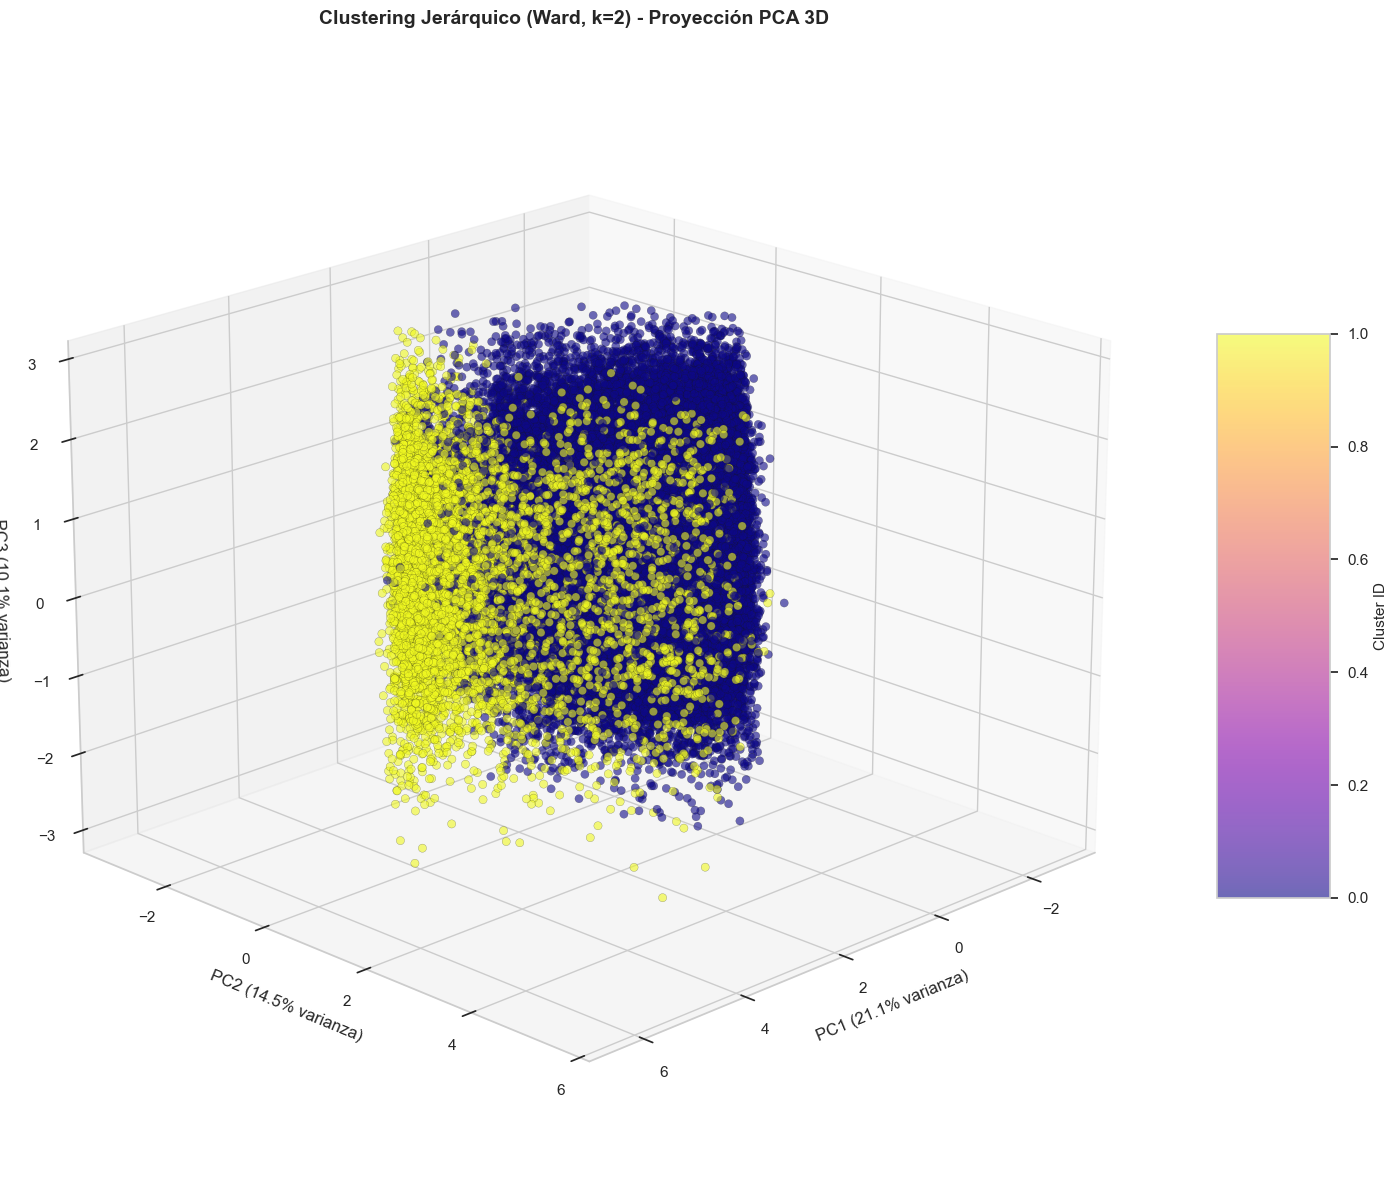


NOTA:
La visualización es una proyección 3D que captura 45.7% de la varianza total.


In [ ]:
# Visualización en espacio PCA 3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_pca_3d[:, 0], df_pca_3d[:, 1], df_pca_3d[:, 2],
                     c=labels_jerarquico, cmap='plasma', 
                     alpha=0.6, s=35, edgecolors='k', linewidth=0.2)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}% varianza)', 
              fontsize=12, labelpad=10)

ax.set_title(f'Clustering Jerárquico ({mejor_metodo.capitalize()}, k={k_optimo}) - Proyección PCA 3D', 
         fontweight='bold', fontsize=14, pad=20)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Cluster ID', fontsize=11)

ax.grid(True, alpha=0.3)
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()

print('\nNOTA:')
print('La visualización es una proyección 3D que captura', end=' ')
print(f'{pca_3d.explained_variance_ratio_.sum()*100:.1f}% de la varianza total.')

ANÁLISIS DE RIESGO POR CLUSTER - JERÁRQUICO


N_Impagos  Tasa_Impago  N_Total
Cluster_Jerarquico                                 
0                        5311       0.1236    42955
1                         730       0.0925     7889

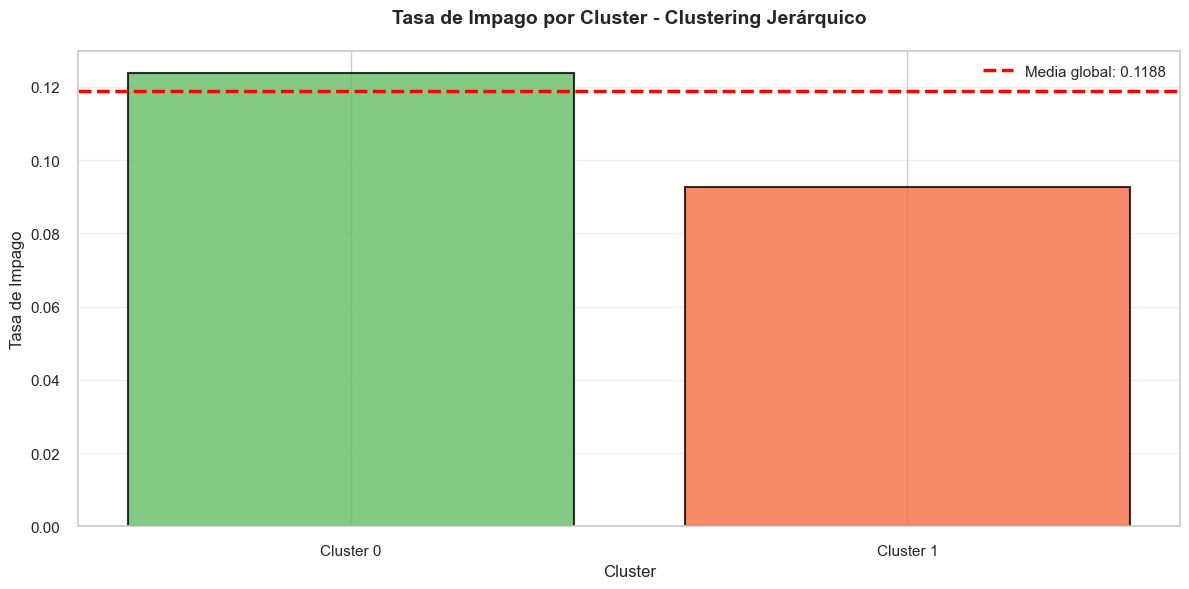

In [ ]:
# Análisis de riesgo por cluster jerárquico

analisis_riesgo_jer = df_original.groupby('Cluster_Jerarquico').agg({
    'Impago': ['sum', 'mean', 'count']
})

analisis_riesgo_jer.columns = ['N_Impagos', 'Tasa_Impago', 'N_Total']
analisis_riesgo_jer = analisis_riesgo_jer.sort_values('Tasa_Impago', ascending=False)


print('ANÁLISIS DE RIESGO POR CLUSTER - JERÁRQUICO')

display(analisis_riesgo_jer)

# Visualización
plt.figure(figsize=(12, 6))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, k_optimo))
plt.bar(range(k_optimo), 
       [analisis_riesgo_jer.loc[i, 'Tasa_Impago'] for i in range(k_optimo)],
       color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

plt.axhline(y=df_original['Impago'].mean(), color='red', linestyle='--', 
           linewidth=2.5, label=f'Media global: {df_original["Impago"].mean():.4f}')

plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Tasa de Impago', fontsize=12)
plt.title('Tasa de Impago por Cluster - Clustering Jerárquico', fontweight='bold', fontsize=14, pad=20)
plt.xticks(range(k_optimo), [f'Cluster {i}' for i in range(k_optimo)])
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. DBSCAN - Clustering Basado en Densidad

### 9.1 Determinación de Hiperparámetros

**Parámetros de DBSCAN:**

1. **eps (ε)**: Radio de vecindad para considerar puntos como vecinos
2. **min_samples (MinPts)**: Número mínimo de puntos para formar un cluster denso

**Método de selección:**

- **MinPts**: Heurística recomendada = dimensionalidad + 1 (en este caso: 10 + 1 = 11)
- **eps**: Se determina mediante el gráfico k-distance en el percentil 75 del k-distance plot

**Ventaja de DBSCAN:**

- Identifica clusters de forma arbitraria
- Detecta outliers como ruido
- No requiere especificar número de clusters a priori

**Limitación:**

- Sensible a la escala y densidad variable de los datos

Dimensionalidad: 10
MinPts recomendado: 11


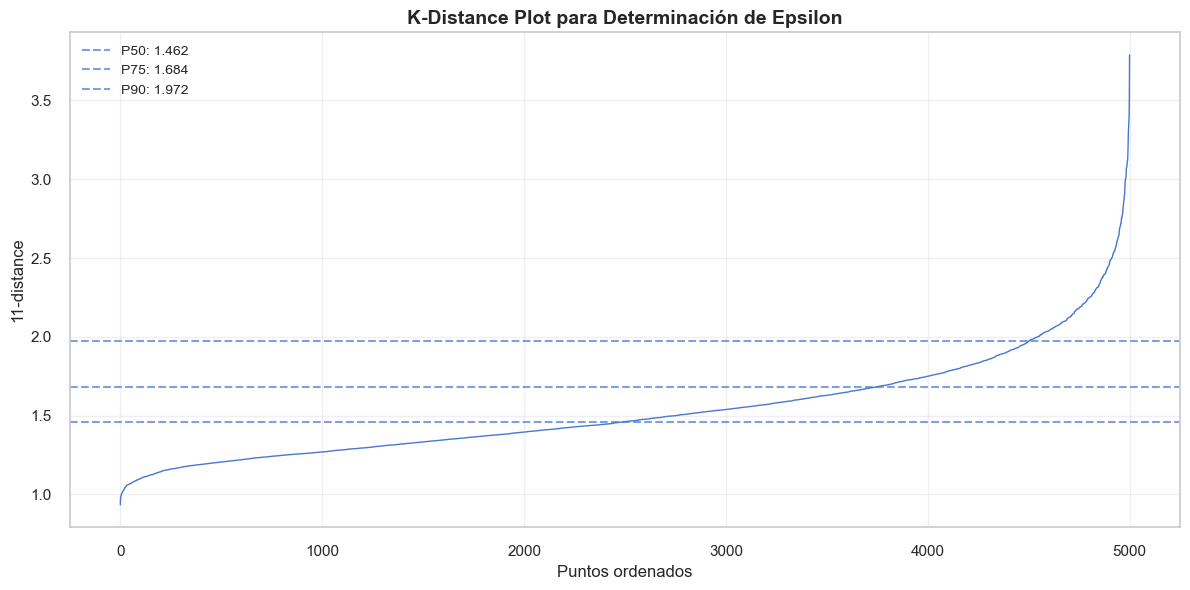


Epsilon sugerido (P75): 1.6836


In [ ]:
# Usar muestra para k-distance (eficiencia computacional)
muestra_size = min(5000, len(df_scaled))
np.random.seed(42)
idx_muestra = np.random.choice(len(df_scaled), muestra_size, replace=False)
df_muestra = df_scaled.iloc[idx_muestra]

# Calcular MinPts según heurística
n_dims = df_scaled.shape[1]
minpts = n_dims + 1

print(f'Dimensionalidad: {n_dims}')
print(f'MinPts recomendado: {minpts}')

# Calcular k-distances
neighbors = NearestNeighbors(n_neighbors=minpts)
neighbors.fit(df_muestra)
distances, _ = neighbors.kneighbors(df_muestra)
k_distances = np.sort(distances[:, -1])

# Visualización k-distance plot
plt.figure(figsize=(12, 6))
plt.plot(k_distances, linewidth=1)
plt.xlabel('Puntos ordenados', fontsize=12)
plt.ylabel(f'{minpts}-distance', fontsize=12)
plt.title('K-Distance Plot para Determinación de Epsilon', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

# Líneas de referencia en percentiles
percentiles = [50, 75, 90]
for p in percentiles:
    eps_p = np.percentile(k_distances, p)
    plt.axhline(y=eps_p, linestyle='--', alpha=0.7, label=f'P{p}: {eps_p:.3f}')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Seleccionar epsilon
eps_sugerido = np.percentile(k_distances, 75)
print(f'\nEpsilon sugerido (P75): {eps_sugerido:.4f}')

### 9.2 Búsqueda de Hiperparámetros Óptimos

In [ ]:
# Evaluación de combinaciones de hiperparámetros

epsilon_vals = [np.percentile(k_distances, p) for p in [50, 75, 90]]
minpts_vals = [minpts-1, minpts, minpts+1]

resultados_dbscan = []


print('EVALUACIÓN DE HIPERPARÁMETROS DBSCAN')

print(f"{'Epsilon':>10} | {'MinPts':>8} | {'N_Clusters':>12} | {'Ruido (%)':>12} | {'Silueta':>10}")
print('-'*90)

for eps in epsilon_vals:
    for mp in minpts_vals:
        # Entrenar DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=mp)
        labels_db = dbscan.fit_predict(df_scaled)
        
        # Calcular métricas
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise = list(labels_db).count(-1)
        pct_noise = (n_noise / len(labels_db)) * 100
        
        # Silueta solo si hay más de 1 cluster y menos del 100% ruido
        if n_clusters > 1 and n_noise < len(labels_db):
            # Calcular silueta excluyendo ruido
            mask_no_noise = labels_db != -1
            if mask_no_noise.sum() > 0:
                sil = silhouette_score(df_scaled[mask_no_noise], labels_db[mask_no_noise])
            else:
                sil = -1.0
        else:
            sil = -1.0
        
        resultados_dbscan.append({
            'eps': eps,
            'min_samples': mp,
            'n_clusters': n_clusters,
            'pct_noise': pct_noise,
            'silhouette': sil,
            'labels': labels_db
        })
        
        print(f"{eps:>10.4f} | {mp:>8} | {n_clusters:>12} | {pct_noise:>11.2f}% | {sil:>10.4f}")

print('='*90)

# Seleccionar mejor configuración
# Criterio: Máxima silueta con ruido < 20%
configs_validas = [r for r in resultados_dbscan if r['pct_noise'] < 20 and r['n_clusters'] > 1]

if configs_validas:
    mejor_dbscan = max(configs_validas, key=lambda x: x['silhouette'])
    print(f'\nMejor configuración DBSCAN:')
    print(f"  Epsilon: {mejor_dbscan['eps']:.4f}")
    print(f"  MinPts: {mejor_dbscan['min_samples']}")
    print(f"  Clusters encontrados: {mejor_dbscan['n_clusters']}")
    print(f"  Ruido: {mejor_dbscan['pct_noise']:.2f}%")
    print(f"  Silueta: {mejor_dbscan['silhouette']:.4f}")
else:
    print('\nNOTA: No se encontraron configuraciones válidas con ruido < 20%')
    print('DBSCAN no identifica estructura de densidad clara en estos datos')
    mejor_dbscan = resultados_dbscan[0]  # Usar primera configuración como referencia

EVALUACIÓN DE HIPERPARÁMETROS DBSCAN
   Epsilon |   MinPts |   N_Clusters |    Ruido (%) |    Silueta
------------------------------------------------------------------------------------------
    1.4621 |       10 |            8 |        1.36% |     0.1398
    1.4621 |       11 |            8 |        1.51% |     0.1401
    1.4621 |       12 |            8 |        1.64% |     0.1404
    1.6836 |       10 |            8 |        0.34% |     0.1379
    1.6836 |       11 |            8 |        0.40% |     0.1380
    1.6836 |       12 |            8 |        0.46% |     0.1381
    1.9716 |       10 |            8 |        0.06% |     0.1373
    1.9716 |       11 |            8 |        0.07% |     0.1374
    1.9716 |       12 |            8 |        0.07% |     0.1374

Mejor configuración DBSCAN:
  Epsilon: 1.4621
  MinPts: 12
  Clusters encontrados: 8
  Ruido: 1.64%
  Silueta: 0.1404


### 9.3 Modelo DBSCAN Final

**Nota:** DBSCAN puede no encontrar estructura de clusters en datos uniformemente distribuidos. En este caso, el bajo número de clusters indica que los datos no presentan regiones de alta densidad claramente separadas.

MODELO DBSCAN FINAL

Parámetros:
  Epsilon (eps): 1.4621
  MinPts: 12

Resultados:
  Clusters identificados: 8
  Puntos de ruido: 834 (1.64%)
  Silueta (sin ruido): 0.1404

Distribución por cluster:
--------------------------------------------------------------------------------
  Ruido:        834 ( 1.64%)
  Cluster 0:  6,247 (12.29%)
  Cluster 1:  6,270 (12.33%)
  Cluster 2:  6,352 (12.49%)
  Cluster 3:  6,134 (12.06%)
  Cluster 4:  6,266 (12.32%)
  Cluster 5:  6,296 (12.38%)
  Cluster 6:  6,278 (12.35%)
  Cluster 7:  6,167 (12.13%)


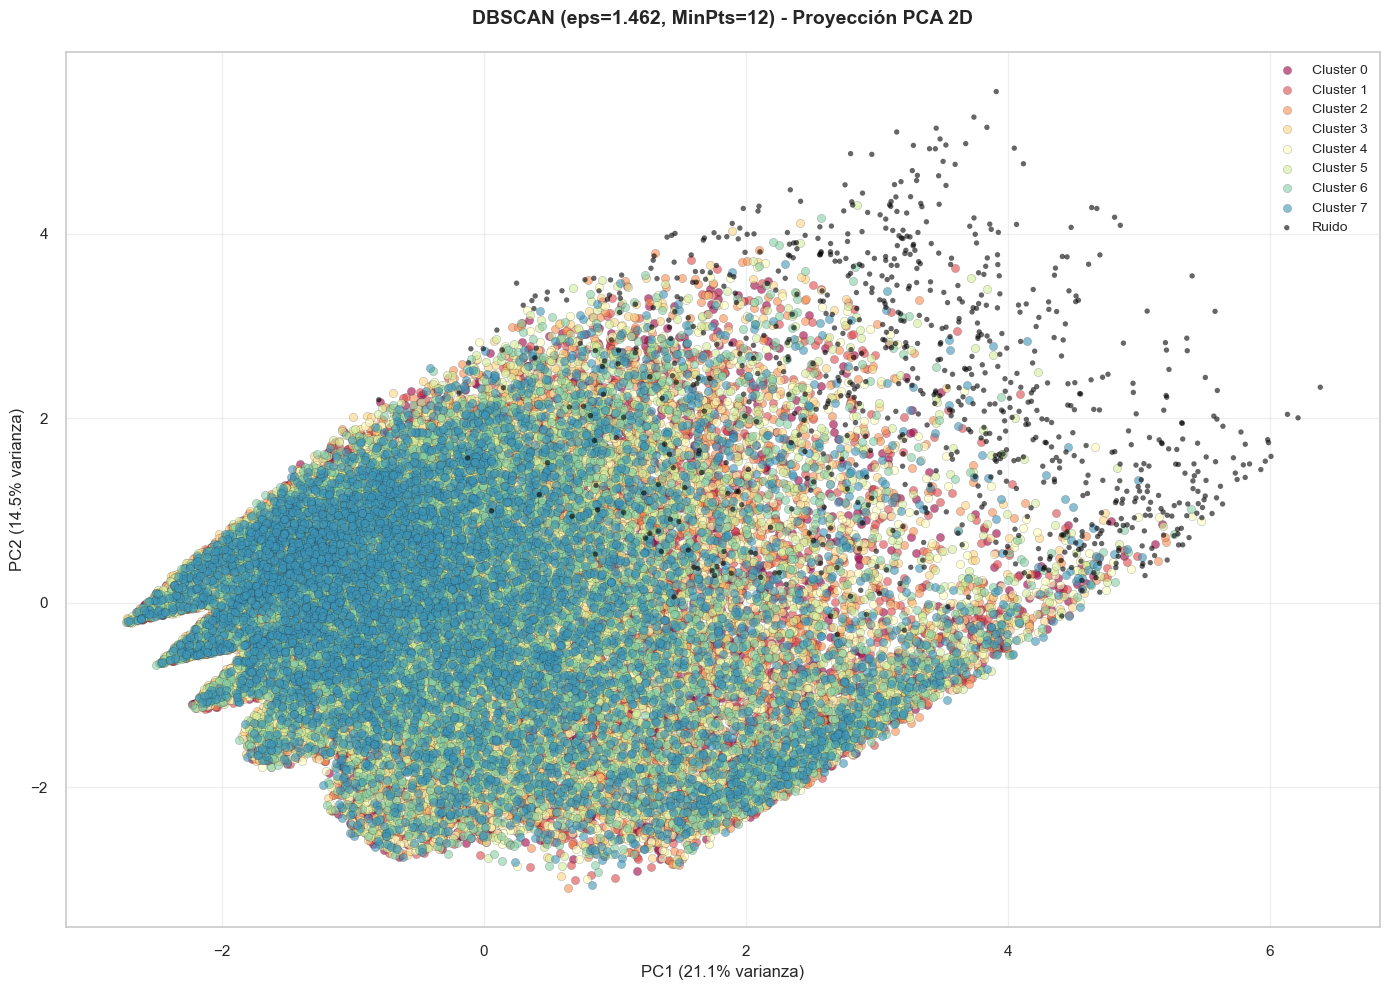

In [ ]:
# Entrenar DBSCAN final con mejores parámetros
dbscan_final = DBSCAN(eps=mejor_dbscan['eps'], min_samples=mejor_dbscan['min_samples'])
labels_dbscan = dbscan_final.fit_predict(df_scaled)

df_original['Cluster_DBSCAN'] = labels_dbscan


print('MODELO DBSCAN FINAL')

print(f"\nParámetros:")
print(f"  Epsilon (eps): {mejor_dbscan['eps']:.4f}")
print(f"  MinPts: {mejor_dbscan['min_samples']}")

print(f"\nResultados:")
print(f"  Clusters identificados: {mejor_dbscan['n_clusters']}")
print(f"  Puntos de ruido: {list(labels_dbscan).count(-1):,} ({mejor_dbscan['pct_noise']:.2f}%)")

if mejor_dbscan['n_clusters'] > 1:
    print(f"  Silueta (sin ruido): {mejor_dbscan['silhouette']:.4f}")

print(f"\nDistribución por cluster:")
print('-'*80)
unique, counts = np.unique(labels_dbscan, return_counts=True)
for cluster_id, count in zip(unique, counts):
    pct = (count / len(labels_dbscan)) * 100
    if cluster_id == -1:
        print(f"  Ruido:     {count:>6,} ({pct:>5.2f}%)")
    else:
        print(f"  Cluster {cluster_id}: {count:>6,} ({pct:>5.2f}%)")

# Visualización en PCA
plt.figure(figsize=(14, 10))

unique_labels = set(labels_dbscan)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 0.3]
        label = 'Ruido'
        marker_size = 15
    else:
        label = f'Cluster {k}'
        marker_size = 35
    
    mask = labels_dbscan == k
    plt.scatter(df_pca_3d[mask, 0], df_pca_3d[mask, 1],
               c=[col], label=label, alpha=0.6, s=marker_size,
               edgecolors='k' if k != -1 else 'none', linewidth=0.2)

plt.xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}% varianza)', fontsize=12)
plt.ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}% varianza)', fontsize=12)
plt.title(f'DBSCAN (eps={mejor_dbscan["eps"]:.3f}, MinPts={mejor_dbscan["min_samples"]}) - Proyección PCA 2D',
         fontweight='bold', fontsize=14, pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if mejor_dbscan['n_clusters'] <= 1:
    print('\nINTERPRETACIÓN:')
    print('DBSCAN no identificó múltiples clusters densos, lo que sugiere que:')
    print('  - Los datos tienen densidad relativamente uniforme')
    print('  - No existen regiones de alta densidad claramente separadas')
    print('  - Los métodos basados en particionamiento (K-Means) o jerárquicos son más apropiados')

## 10. Comparación Final de Métodos

Evaluación comparativa de los tres algoritmos de clustering aplicados.

In [ ]:
# Tabla comparativa final

comparacion = pd.DataFrame({
    'Método': ['K-Means', 'Jerárquico (' + mejor_metodo.capitalize() + ')', 'DBSCAN'],
    'N_Clusters': [k_optimo, k_optimo, mejor_dbscan['n_clusters']],
    'Silueta': [sil_final, sil_jer, mejor_dbscan['silhouette']],
    'Davies-Bouldin': [db_final, db_jer, np.nan],
    'Calinski-Harabasz': [ch_final, ch_jer, np.nan],
    'Ruido (%)': [0, 0, mejor_dbscan['pct_noise']]
})


print('COMPARACIÓN FINAL DE MÉTODOS DE CLUSTERING')

display(comparacion)

print('\nANÁLISIS COMPARATIVO:')
print('-'*100)

# Determinar mejor método por silueta (excluyendo DBSCAN si tiene 1 cluster)
metodos_validos = comparacion[comparacion['N_Clusters'] > 1]
if len(metodos_validos) > 0:
    mejor_metodo_final = metodos_validos.loc[metodos_validos['Silueta'].idxmax(), 'Método']
    mejor_silueta = metodos_validos.loc[metodos_validos['Silueta'].idxmax(), 'Silueta']
    
    print(f'Mejor método por Coeficiente de Silueta: {mejor_metodo_final}')
    print(f'  Silueta: {mejor_silueta:.4f}')
else:
    print('No se pudo determinar mejor método')

print('\nRECOMENDACIÓN:')
if sil_final >= sil_jer:
    print('  - K-Means ofrece la mejor combinación de calidad y eficiencia computacional')
    print('  - Clusters bien balanceados y centroides interpretables')
else:
    print('  - Clustering Jerárquico ofrece mejor calidad de segmentación')
    print('  - Permite análisis de jerarquía de agrupamientos')

if mejor_dbscan['n_clusters'] <= 1:
    print('  - DBSCAN no identificó estructura de densidad significativa')
    print('  - No recomendado para este dataset')

COMPARACIÓN FINAL DE MÉTODOS DE CLUSTERING


Método  N_Clusters  Silueta  Davies-Bouldin  Calinski-Harabasz  \
0            K-Means           2   0.1585          2.2995          8506.1803   
1  Jerárquico (Ward)           2   0.1728          2.1721          5689.8887   
2             DBSCAN           8   0.1404             NaN                NaN   

   Ruido (%)  
0     0.0000  
1     0.0000  
2     1.6403


ANÁLISIS COMPARATIVO:
----------------------------------------------------------------------------------------------------
Mejor método por Coeficiente de Silueta: Jerárquico (Ward)
  Silueta: 0.1728

RECOMENDACIÓN:
  - Clustering Jerárquico ofrece mejor calidad de segmentación
  - Permite análisis de jerarquía de agrupamientos


## 11. Análisis de Validación con Variable Objetivo

Evaluación de cómo los clusters se relacionan con la variable objetivo (Impago).

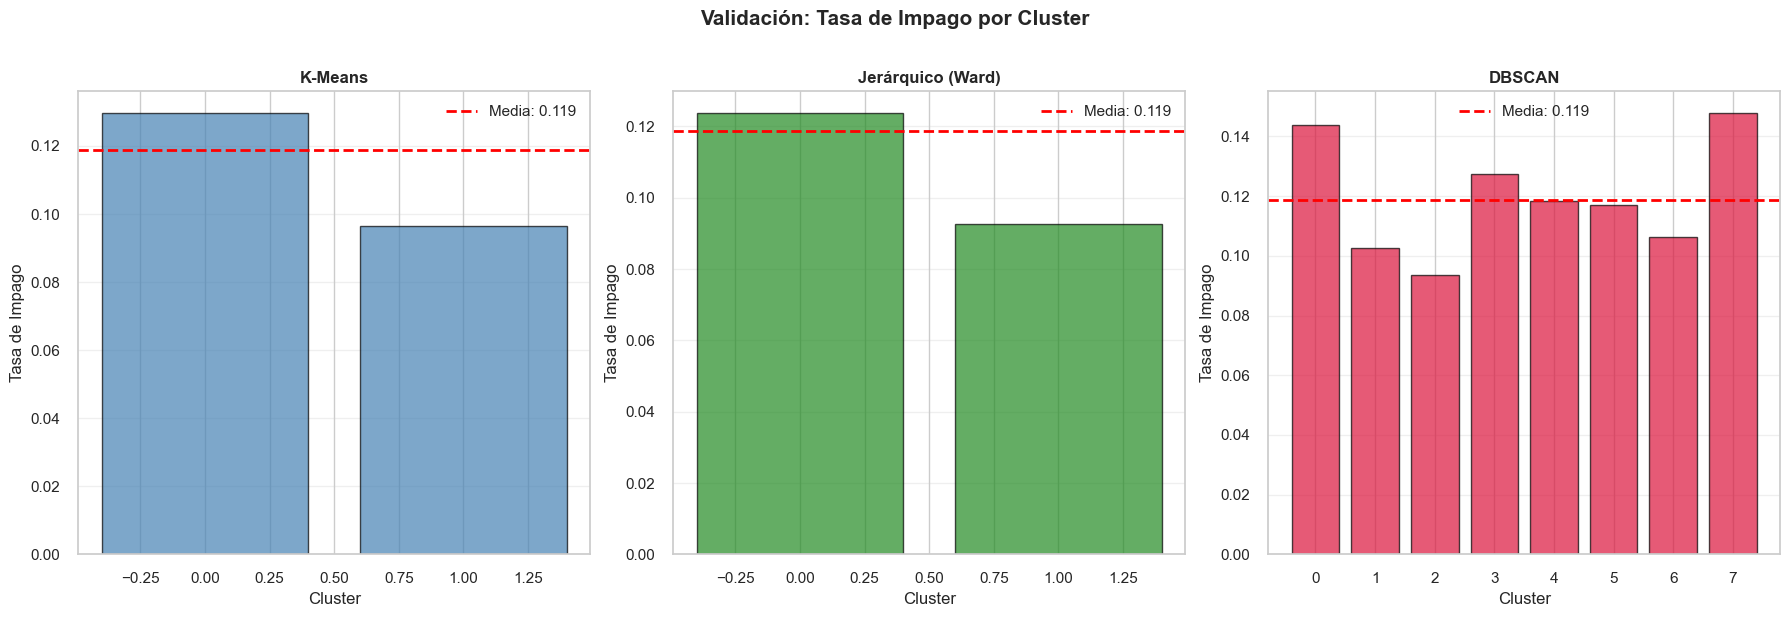

CAPACIDAD DISCRIMINATIVA DE RIESGO POR MÉTODO

Varianza de tasas de impago entre clusters:
  K-Means:    0.000274
  Jerárquico: 0.000242

K-Means muestra mayor diferenciación de riesgo entre clusters


In [ ]:
# Comparación de tasa de impago entre métodos

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-Means
tasas_km = [df_original[df_original['Cluster_KMeans']==i]['Impago'].mean() 
            for i in range(k_optimo)]
axes[0].bar(range(k_optimo), tasas_km, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=df_original['Impago'].mean(), color='red', linestyle='--', linewidth=2,
               label=f'Media: {df_original["Impago"].mean():.3f}')
axes[0].set_title('K-Means', fontweight='bold')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Tasa de Impago')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Jerárquico
tasas_jer = [df_original[df_original['Cluster_Jerarquico']==i]['Impago'].mean() 
             for i in range(k_optimo)]
axes[1].bar(range(k_optimo), tasas_jer, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1].axhline(y=df_original['Impago'].mean(), color='red', linestyle='--', linewidth=2,
               label=f'Media: {df_original["Impago"].mean():.3f}')
axes[1].set_title(f'Jerárquico ({mejor_metodo.capitalize()})', fontweight='bold')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Tasa de Impago')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# DBSCAN
if mejor_dbscan['n_clusters'] > 1:
    clusters_db = [c for c in np.unique(labels_dbscan) if c != -1]
    tasas_db = [df_original[df_original['Cluster_DBSCAN']==i]['Impago'].mean() 
                for i in clusters_db]
    axes[2].bar(range(len(clusters_db)), tasas_db, color='crimson', alpha=0.7, edgecolor='black')
    axes[2].axhline(y=df_original['Impago'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Media: {df_original["Impago"].mean():.3f}')
    axes[2].set_title('DBSCAN', fontweight='bold')
    axes[2].set_xlabel('Cluster')
    axes[2].set_ylabel('Tasa de Impago')
    axes[2].legend()
    axes[2].grid(axis='y', alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'DBSCAN:\nNo identificó\nmúltiples clusters',
                ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
    axes[2].set_title('DBSCAN', fontweight='bold')

plt.suptitle('Validación: Tasa de Impago por Cluster', fontweight='bold', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

# Análisis estadístico

print('CAPACIDAD DISCRIMINATIVA DE RIESGO POR MÉTODO')


# Variabilidad de tasas de impago (mayor variabilidad = mejor discriminación)
var_km = np.var(tasas_km)
var_jer = np.var(tasas_jer)

print(f'\nVarianza de tasas de impago entre clusters:')
print(f'  K-Means:    {var_km:.6f}')
print(f'  Jerárquico: {var_jer:.6f}')

if var_km > var_jer:
    print('\nK-Means muestra mayor diferenciación de riesgo entre clusters')
else:
    print('\nClustering Jerárquico muestra mayor diferenciación de riesgo entre clusters')

In [ ]:
# Exportar resultados finales

# Crear dataset con todas las asignaciones de clusters
df_resultados = df_original.drop(columns=['Cluster_Jerarquico', 'Cluster_DBSCAN'], errors='ignore')
display(df_resultados)

# Guardar a CSV
df_resultados.to_csv('Datos/Transformados/clustering_final.csv', index=True)

print('\nResultados exportados en: resultados_clustering_final.csv')
print(f'\nTotal de observaciones procesadas: {len(df_resultados):,}')
print(f'Métodos aplicados: K-Means, Clustering Jerárquico ({mejor_metodo.capitalize()}), DBSCAN')
print(f'Número óptimo de clusters: {k_optimo}')
print(f'\nMejor método por Silueta: {mejor_metodo_final if "mejor_metodo_final" in locals() else "K-Means"}')
print('\nAnálisis preparado para revisión y aplicación de negocio.')

Edad  Ingresos  Monto_Inicial  Scoring_Crediticio  Meses_Empleo  \
ID                                                                        
S97R7X    18     16000           5000                 397            19   
RLGTBY    50     62116          37278                 486           217   
SKE2P9    37     37602          44532                 765           150   
E2FB1D    56     67410          23752                 643           369   
TKSCGH    35     35930          28440                 645           136   
...      ...       ...            ...                 ...           ...   
G5QJ7O    54     34694          11345                 501           307   
FKB7Z1    35     53194          27149                 378           115   
O5PRET    57     50658          41656                 645           346   
WZEOVA    53     66601          12391                 400           274   
O0VB8P    66     38477          12995                 436           431   

        Num_Creditos  Ratio_Interes  Duracion  Ratio_Deuda_Ingresos  Estudios  \
ID                                                                              
S97R7X             1         8.0600        48                0.1000         0   
RLGTBY             3        21.9600        12                0.5500         1   
SKE2P9             3        11.2000        60                0.2300         1   
E2FB1D             1        21.2400        24                0.1800         1   
TKSCGH             3        16.9500        12                0.5500         1   
...              ...            ...       ...                   ...       ...   
G5QJ7O             3        22.4400        36                0.1000         1   
FKB7Z1             4        18.2100        60                0.1000         2   
O5PRET             4        18.8400        24                0.4700         1   
WZEOVA             1         3.3500        12                0.2100         2   
O0VB8P             2        21.9800        24                0.1600         0   

        Posesion_Hipoteca  Personas_Cargo  Fiador  Impago    Prima  \
ID                                                                   
S97R7X                  1               0       0       0  50.1200   
RLGTBY                  1               0       1       1 800.0000   
SKE2P9                  1               1       1       0 356.3000   
E2FB1D                  0               1       0       0 198.7200   
TKSCGH                  1               1       1       0 484.2000   
...                   ...             ...     ...     ...      ...   
G5QJ7O                  0               1       1       0 183.9300   
FKB7Z1                  0               1       1       0 616.0100   
O5PRET                  0               1       1       0 762.3600   
WZEOVA                  0               0       1       0  82.8000   
O0VB8P                  1               1       1       0 181.5300   

        Tipo_Jornada_Laboral_Autónomo  Tipo_Jornada_Laboral_Desempleado  \
ID                                                                        
S97R7X                              1                                 0   
RLGTBY                              0                                 0   
SKE2P9                              0                                 0   
E2FB1D                              1                                 0   
TKSCGH                              0                                 0   
...                               ...                               ...   
G5QJ7O                              0                                 1   
FKB7Z1                              0                                 1   
O5PRET                              1                                 0   
WZEOVA                              0                                 1   
O0VB8P                              0                                 1   

        Tipo_Jornada_Laboral_Jornada completa  \
ID                                        


Resultados exportados en: resultados_clustering_final.csv

Total de observaciones procesadas: 50,844
Métodos aplicados: K-Means, Clustering Jerárquico (Ward), DBSCAN
Número óptimo de clusters: 2

Mejor método por Silueta: Jerárquico (Ward)

Análisis preparado para revisión y aplicación de negocio.
